# Load packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tsai
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

tsai       : 0.2.17
fastai     : 2.3.1
fastcore   : 1.3.19
torch      : 1.8.1+cu111


In [3]:
torch.cuda.get_device_name(0)

'GeForce RTX 2070'

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib import ticker

In [5]:
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
           'legend.fontsize': med,
           'figure.figsize': (10, 6),
           'axes.labelsize': med,
           'axes.titlesize': med,
           'xtick.labelsize': med,
           'ytick.labelsize': med,
           'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

# Version
print(mpl.__version__)
print(sns.__version__)

3.3.2
0.11.0


In [6]:
import hyperopt
print(hyperopt.__version__)
from hyperopt import Trials, STATUS_OK, STATUS_FAIL, tpe, fmin, hp
from hyperopt import space_eval

0.2.5


In [7]:
import time
from fastai.callback.tracker import EarlyStoppingCallback
import gc

In [8]:
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Specify parameters

In [9]:
file_name = "../OD_pair/GEANT-OD_pair.csv"  # the input filename
history = 10  # input historical time steps
horizon = 1  # output predicted time steps
test_ratio = 0.2  # testing data ratio
max_evals = 100  # maximal trials for hyper parameter tuning

model_name = 'MLP'
y_true_fn = '%s_true_TM-minmax-%d-%d.pkl' % (model_name, history, horizon)
y_pred_fn = '%s_pred_TM-minmax-%d-%d.pkl' % (model_name, history, horizon)

RMSE_fn = model_name + '_TM-minmax_RMSE-%d-%d-step-%d.pdf'
MAE_fn = model_name + '_TM-minmax_MAE-%d-%d-step-%d.pdf'

In [10]:
y_true_fn

'MLP_true_TM-minmax-10-1.pkl'

In [11]:
y_pred_fn

'MLP_pred_TM-minmax-10-1.pkl'

# Load data

In [12]:
df = pd.read_csv(file_name)

In [13]:
df.head()

time  OD_1-1       OD_1-2        OD_1-3        OD_1-4  \
0  2005-05-04-15-30     0.0  16760.79111  12407.777780  10453.848890   
1  2005-05-04-15-45     0.0  16346.46222   9373.208889   8439.048889   
2  2005-05-04-16-00     0.0  16755.22667  10638.302220  12623.520000   
3  2005-05-04-16-15     0.0  18488.00889  12263.697780  13389.128890   
4  2005-05-04-16-30     0.0  13748.27556  11323.333330  14048.426670   

        OD_1-5       OD_1-6       OD_1-7       OD_1-8       OD_1-9  ...  \
0  1468.631111  4768.444444  25290.37333  2468.515556  7984.213333  ...   
1  1032.906667  1649.520000  14433.05778  3182.986667  7243.173333  ...   
2   721.226667  1693.057778  17066.67556  5304.195556  6696.844444  ...   
3   995.600000  2984.231111  13325.22667  6248.248889  5719.804444  ...   
4   804.044444  2698.124444  16651.25333  5761.528889  5088.204444  ...   

   OD_23-14    OD_23-15     OD_23-16     OD_23-17     OD_23-18     OD_23-19  \
0       0.0  211.395556  1212.666667  1026.391111  51508.78222  1488.951111   
1       0.0  190.142222  1079.751111   529.617778  44913.43111  1410.400000   
2       0.0   51.048889  1750.631111    81.760000  47603.85778  1016.977778   
3       0.0  217.911111  3313.120000   356.000000  47023.99111  1092.017778   
4       0.0  292.071111  4479.644444   541.288889  47737.10222  1139.217778   

      OD_23-20     OD_23-21   OD_23-22  OD_23-23  
0  175293.2444  3247.164444  14.106667       0.0  
1  148162.8711  3669.173333   6.880000       0.0  
2  154312.8711  3452.320000  24.488889       0.0  
3  148199.6622  3300.613333  36.951111       0.0  
4  147601.5467  4073.137778  59.848889       0.0  

[5 rows x 530 columns]

Parse the time column:

In [14]:
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d-%H-%M')  # Parse the time

Remove the outliers:

In [15]:
data_columns = list(df.columns.values)
data_columns.remove('time')
data = df[data_columns].values
data = np.clip(data, 0.0, np.percentile(data.flatten(), 99))  # we use 99% as the threshold
df[data_columns] = data

# Split the data

Split the data based on the test_ratio parameter. Aggreate the data and plot the training/testing split first:

In [16]:
aggregated_time_series = np.sum(data, axis=1)
df_ts = pd.DataFrame()
df_ts['date'] = df['time']
df_ts['data'] = aggregated_time_series / 1000  # Plot in Mbps

# add a datetimeindex
dates = pd.DatetimeIndex(df_ts['date'])
df_ts = df_ts.set_index(dates).asfreq('15T') 

In [17]:
test_length = int(df.shape[0] * test_ratio)
train_length = df.shape[0] - test_length

In [18]:
df_ts.index[train_length:][0]

Timestamp('2005-08-02 09:30:00', freq='15T')

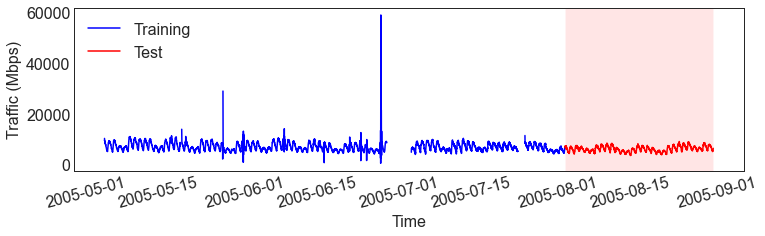

In [20]:
plt.figure(figsize=[12, 3])
plt.plot(df_ts.index[:train_length], df_ts['data'][:train_length], label='Training', color='blue')
plt.plot(df_ts.index[train_length:], df_ts['data'][train_length:], label='Test', color='red')
plt.axvspan(df_ts.index[train_length:][0], df_ts.index[train_length:][-1],  facecolor='r', alpha=0.1)

plt.xlabel('Time')
plt.ylabel('Traffic (Mbps)')
plt.legend(loc='best')
plt.xticks(rotation=15)
# plt.show()
plt.savefig('training_test_split.pdf', bbox_inches = 'tight', pad_inches = 0.1)

Plot the training / testing split:

# Normalize the data

Calculate the min and max data based on the training data set:

In [20]:
max_list = np.max(data[:train_length], axis=0)

In [21]:
min_list = np.min(data[:train_length], axis=0)

Normalize the data and fill the data:

In [22]:
data = (data - min_list) / (max_list - min_list)
data[np.isnan(data)] = 0  # fill the abnormal data with 0
data[np.isinf(data)] = 0

In [23]:
print(np.max(data[:train_length].flatten()))

1.0


In [24]:
print(np.min(data[:train_length].flatten()))

0.0


The training data is in a range of [0, 1] but the test data may be out of this range:

In [25]:
print(np.max(data.flatten()))

4.931113265982958


In [26]:
print(np.min(data.flatten()))

-0.003975552580138194


# Build the supervised prediction problem

The input data is in the following format:
* x_data as input features: [data size, input historical steps, input channels]. Here the input channel number is the OD pair number.
* y_data as output targets: [data size, output prediction steps, output channels].

In [27]:
x_data = []
y_data = []

In [28]:
length = data.shape[0]
print(length)

10769


In [29]:
for i in range(length - history - horizon + 1):
    x = data[i:i+history, :]  # input historical time steps
    y = data[i+history:i+history+horizon:, :]  # output predicted time steps
    x_data.append(x)
    y_data.append(y)

In [30]:
x_data = np.array(x_data)
y_data = np.array(y_data)

In [31]:
x_data.shape

(10759, 10, 529)

In [32]:
y_data.shape

(10759, 1, 529)

Reshape x_data:

In [33]:
x_data = np.swapaxes(x_data, 1, 2)

Reshape y_data:

In [34]:
y_data = y_data.reshape(y_data.shape[0], -1)
y_data.shape

(10759, 529)

The last test_length samples are fixed as test data. The training data size may vary with the input historical time steps. The test data size may vary with the prediction horizon.

In [35]:
test_length = test_length - horizon + 1

In [36]:
train_valid_length = x_data.shape[0] - test_length

In [37]:
train_valid_length

8606

We further split a valid data set for hyper parameter tuning:

In [38]:
train_length = int(train_valid_length * 0.8)
valid_length = train_valid_length - train_length

In [39]:
train_length

6884

In [40]:
valid_length

1722

In [41]:
X_train = x_data[:train_length]
y_train = y_data[:train_length]
X_valid = x_data[train_length:train_valid_length]
y_valid = y_data[train_length:train_valid_length]
X_test = x_data[train_valid_length:]
y_test = y_data[train_valid_length:]

In [42]:
X_train.shape

(6884, 529, 10)

In [43]:
y_train.shape

(6884, 529)

In [44]:
X_valid.shape

(1722, 529, 10)

In [45]:
y_valid.shape

(1722, 529)

In [46]:
X_test.shape

(2153, 529, 10)

In [47]:
y_test.shape

(2153, 529)

# Build TSAI Datasets

Now we are ready to use the tsai package with its dataset definition:

In [48]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [49]:
X.shape

(8606, 529, 10)

In [50]:
y.shape

(8606, 529)

In [51]:
splits

((#6884) [0,1,2,3,4,5,6,7,8,9...],
 (#1722) [6884,6885,6886,6887,6888,6889,6890,6891,6892,6893...])

Make sure this is a regression task, instead of a classification task (using TSRegression as follows):

In [52]:
tfms  = [None, [TSRegression()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dsets

(#8606) [(TSTensor(vars:529, len:10), tensor([0.0000e+00, 8.9423e-02, 3.7106e-01, 1.0264e-01, 7.2026e-02, 3.4304e-03,
        7.1890e-02, 1.2682e-02, 2.5281e-02, 9.1491e-03, 5.0183e-03, 1.2151e-01,
        0.0000e+00, 5.6280e-05, 1.8669e-02, 3.2046e-01, 3.0214e-02, 4.0630e-01,
        5.0114e-02, 6.6921e-02, 1.0054e-04, 0.0000e+00, 2.1455e-01, 0.0000e+00,
        7.3656e-01, 2.4451e-03, 1.4999e-02, 9.5933e-04, 1.4186e-01, 9.6139e-03,
        7.5581e-03, 5.6137e-01, 1.3439e-03, 7.8781e-03, 4.1034e-02, 1.0031e-02,
        5.2605e-03, 3.9400e-03, 5.2090e-02, 4.1799e-03, 2.3216e-02, 6.7784e-02,
        3.5897e-02, 1.7727e-01, 4.3577e-03, 5.7287e-01, 0.0000e+00, 7.6272e-02,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0254e-04, 6.5089e-03, 1.7143e-03,
        1.1740e-01, 4.1891e-02, 7.4133e-03, 1.8199e-02, 1.3436e-02, 1.7860e-04,
        1.5109e-02, 1.5142e-02, 7.8321e-04, 1.5964e-02, 9.8029e-04, 2.2297e-02,
        8.7682e-02, 7.0101e-04, 8.7537e-03, 0.0000e+00, 2.1880e-01, 0.0000e+00,
  

# Model Building and Hyperparameter Tuning

We use the hyperopt package to search for hyper parameters:

In [53]:
search_space = {
    'batch_size': hp.choice('bs', [16, 32, 64, 128]),
    "lr": hp.choice('lr', [0.1, 0.01, 0.001]),
    "epochs": hp.choice('epochs', [20, 50, 100]),  # we would also use early stopping
    "patience": hp.choice('patience', [5, 10]),  # early stopping patience
    # "optimizer": hp.choice('optimizer', [Adam, SGD, RMSProp]),  # https://docs.fast.ai/optimizer
    "optimizer": hp.choice('optimizer', [Adam]),
    # model parameters
    "layers": hp.choice('layers', [[100, 100, 100], [200, 200, 200], [500, 500, 500]]),
    "fc_dropout": hp.choice('fc_dropout', [0.1, 0.2, 0.5])
}

In [54]:
search_space

{'batch_size': <hyperopt.pyll.base.Apply at 0x229acaec448>,
 'lr': <hyperopt.pyll.base.Apply at 0x229acaecd48>,
 'epochs': <hyperopt.pyll.base.Apply at 0x229acaec588>,
 'patience': <hyperopt.pyll.base.Apply at 0x229b8894bc8>,
 'optimizer': <hyperopt.pyll.base.Apply at 0x229acae78c8>,
 'layers': <hyperopt.pyll.base.Apply at 0x229acb3c248>,
 'fc_dropout': <hyperopt.pyll.base.Apply at 0x229b8318bc8>}

In [55]:
# clear memory 
gc.collect()

40

In [56]:
def create_model_hypopt(params):
    
    try:
        # clear memory 
        gc.collect()
        print("Trying params:", params)
        batch_size = params["batch_size"]
    
        # Create data loader
        tfms  = [None, [TSRegression()]]
        dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
        # set num_workers for memory bottleneck
        dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
        # Create model
        arch = MLP
        k = {
            'layers': params['layers'],
            'fc_dropout': params['fc_dropout']
        }
        model = create_model(arch, dls=dls, **k)
        print(model.__class__.__name__)
        
        # Add a Sigmoid layer
        model = nn.Sequential(model, nn.Sigmoid())
    
        # Training the model
        learn = Learner(dls, model, metrics=[mae, rmse], opt_func=params['optimizer'])
        start = time.time()
        learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                            cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
        learn.plot_metrics()
        elapsed = time.time() - start
        print(elapsed)
    
        vals = learn.recorder.values[-1]
        print(vals)
        # vals[0], vals[1], vals[2]
        # train loss, valid loss, accuracy
        val_loss = vals[1]
    
        # delete tmp variables
        del dls
        del model
        del learn
        return {'loss': val_loss, 'status': STATUS_OK} # if accuracy use '-' sign, model is optional
    except:
        return {'loss': None, 'status': STATUS_FAIL}

Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 20, 'fc_dropout': 0.2, 'layers': (200, 200, 200), 'lr': 0.01, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 5}
MLP                                                                                                                    
  0%|                                                                          | 0/100 [00:02<?, ?trial/s, best loss=?]

No improvement since epoch 0: early stopping                                                                           
  0%|                                                                          | 0/100 [00:06<?, ?trial/s, best loss=?]

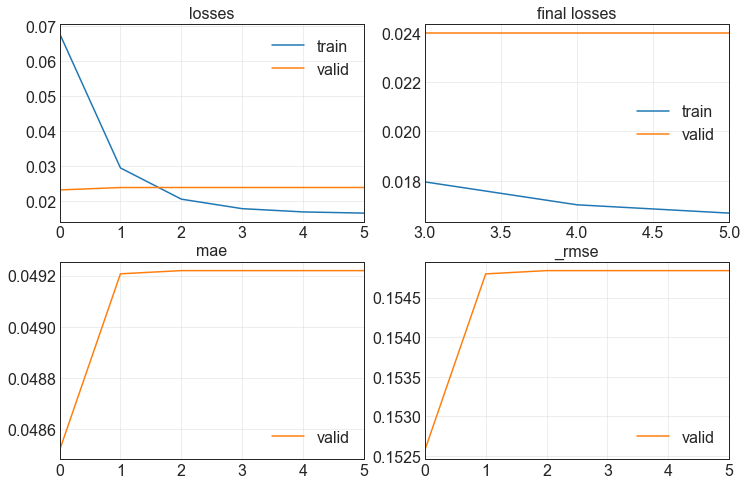

3.5625743865966797                                                                                                     
[0.016686540096998215, 0.023975994437932968, 0.049219612032175064, 0.1548418402671814]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 20, 'fc_dropout': 0.1, 'layers': (200, 200, 200), 'lr': 0.1, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 5}
MLP                                                                                                                    
  1%|▍                                             | 1/100 [00:07<10:42,  6.49s/trial, best loss: 0.023975994437932968]

No improvement since epoch 0: early stopping                                                                           
  1%|▍                                             | 1/100 [00:15<10:42,  6.49s/trial, best loss: 0.023975994437932968]

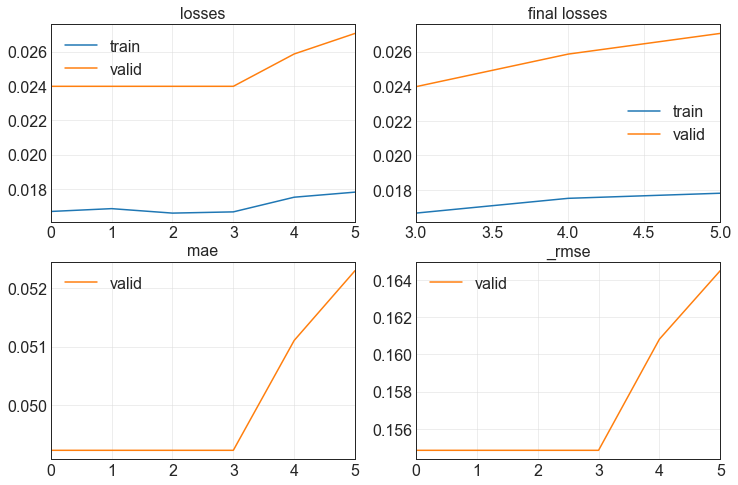

7.869553565979004                                                                                                      
[0.017808696255087852, 0.02705996297299862, 0.052303578704595566, 0.16449911892414093]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'fc_dropout': 0.5, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 5}
MLP                                                                                                                    
  2%|▉                                             | 2/100 [00:17<11:58,  7.34s/trial, best loss: 0.023975994437932968]

No improvement since epoch 22: early stopping                                                                          
  2%|▉                                             | 2/100 [00:28<11:58,  7.34s/trial, best loss: 0.023975994437932968]

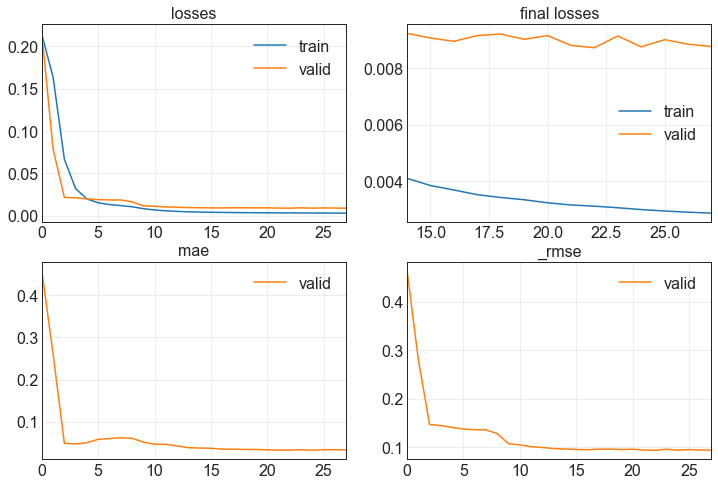

11.898043155670166                                                                                                     
[0.0028756160754710436, 0.00875759869813919, 0.03294290602207184, 0.09358203411102295]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 50, 'fc_dropout': 0.1, 'layers': (200, 200, 200), 'lr': 0.01, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 5}
MLP                                                                                                                    
  3%|█▍                                             | 3/100 [00:30<14:46,  9.14s/trial, best loss: 0.00875759869813919]

No improvement since epoch 16: early stopping                                                                          
  3%|█▍                                             | 3/100 [00:46<14:46,  9.14s/trial, best loss: 0.00875759869813919]

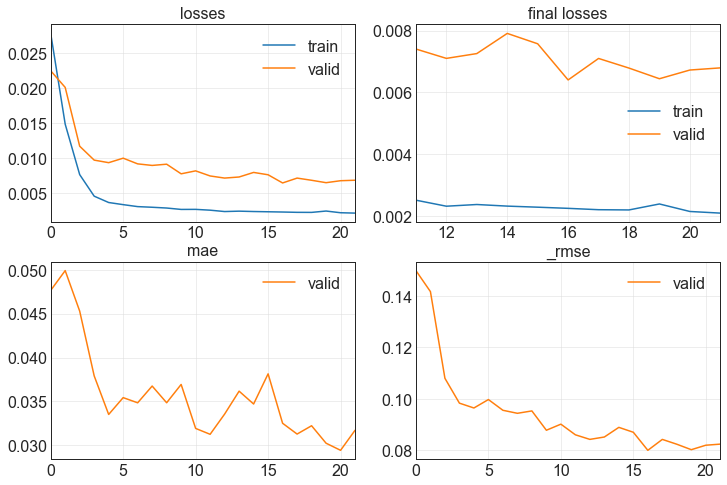

16.624232053756714                                                                                                     
[0.002090160036459565, 0.006794342305511236, 0.03171057999134064, 0.08242779970169067]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 20, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.1, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
  4%|█▊                                            | 4/100 [00:48<18:54, 11.81s/trial, best loss: 0.006794342305511236]

No improvement since epoch 0: early stopping                                                                           
  4%|█▊                                            | 4/100 [01:14<18:54, 11.81s/trial, best loss: 0.006794342305511236]

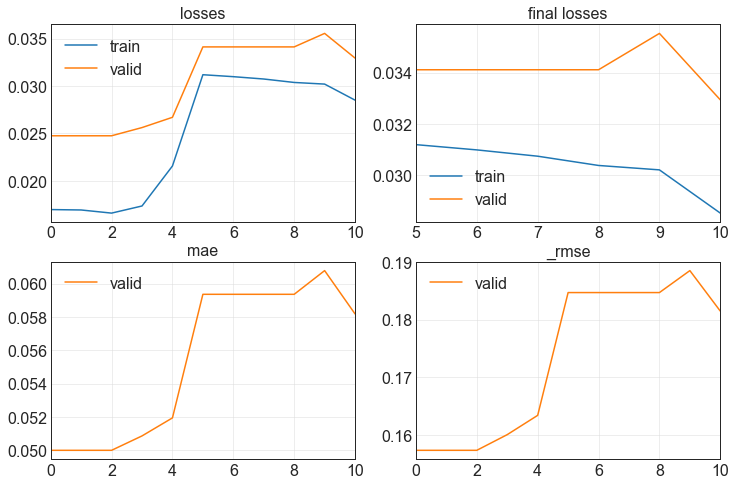

26.56602931022644                                                                                                      
[0.028501765802502632, 0.03293565660715103, 0.05817926675081253, 0.18148185312747955]                                  
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (500, 500, 500), 'lr': 0.1, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
  5%|██▎                                           | 5/100 [01:16<26:23, 16.67s/trial, best loss: 0.006794342305511236]

No improvement since epoch 10: early stopping                                                                          
  5%|██▎                                           | 5/100 [02:06<26:23, 16.67s/trial, best loss: 0.006794342305511236]

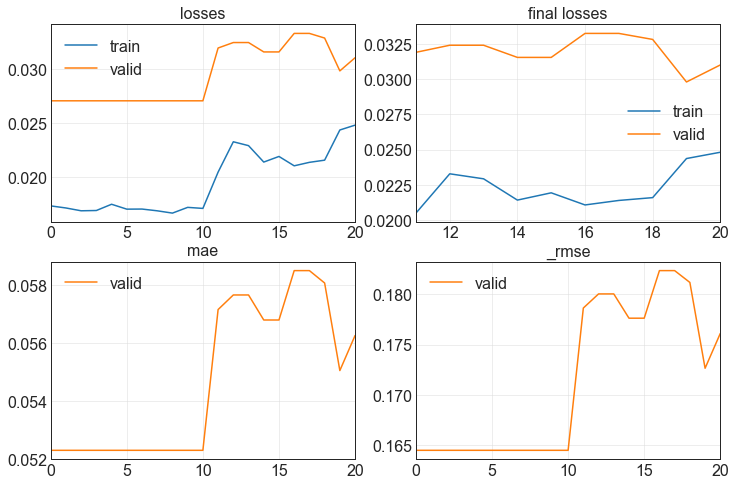

50.60702109336853                                                                                                      
[0.0248133335262537, 0.031017664819955826, 0.056261271238327026, 0.17611832916736603]                                  
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 20, 'fc_dropout': 0.1, 'layers': (200, 200, 200), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 5}
MLP                                                                                                                    
  6%|██▊                                           | 6/100 [02:08<42:44, 27.28s/trial, best loss: 0.006794342305511236]

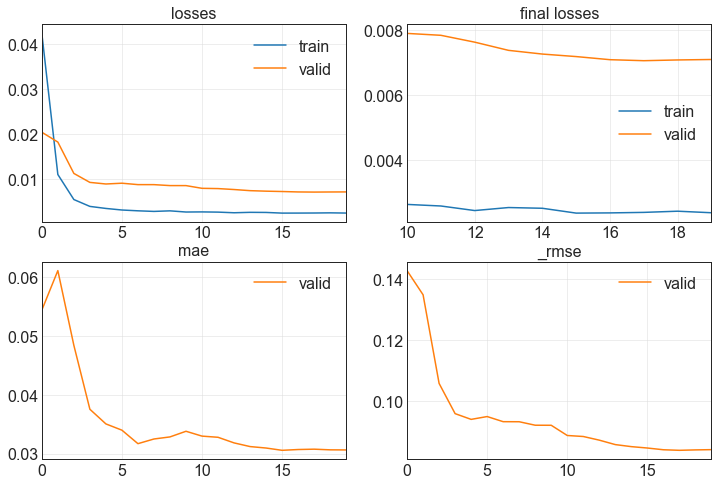

25.573817491531372                                                                                                     
[0.0023849394638091326, 0.007086529396474361, 0.030610959976911545, 0.0841815248131752]                                
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 50, 'fc_dropout': 0.1, 'layers': (100, 100, 100), 'lr': 0.01, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
  7%|███▏                                          | 7/100 [02:35<42:11, 27.22s/trial, best loss: 0.006794342305511236]

No improvement since epoch 12: early stopping                                                                          
  7%|███▏                                          | 7/100 [03:30<42:11, 27.22s/trial, best loss: 0.006794342305511236]

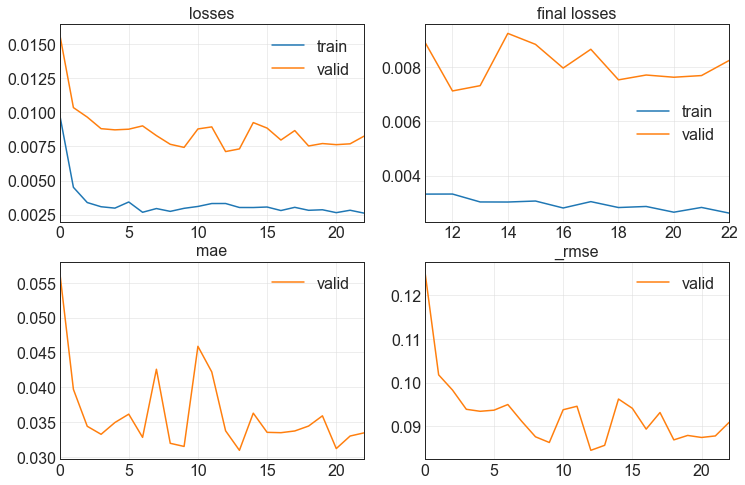

55.280003786087036                                                                                                     
[0.002609026152640581, 0.008255617693066597, 0.03345899656414986, 0.09086043387651443]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 50, 'fc_dropout': 0.1, 'layers': (100, 100, 100), 'lr': 0.01, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
  8%|███▋                                          | 8/100 [03:32<55:22, 36.11s/trial, best loss: 0.006794342305511236]

No improvement since epoch 29: early stopping                                                                          
  8%|███▋                                          | 8/100 [03:49<55:22, 36.11s/trial, best loss: 0.006794342305511236]

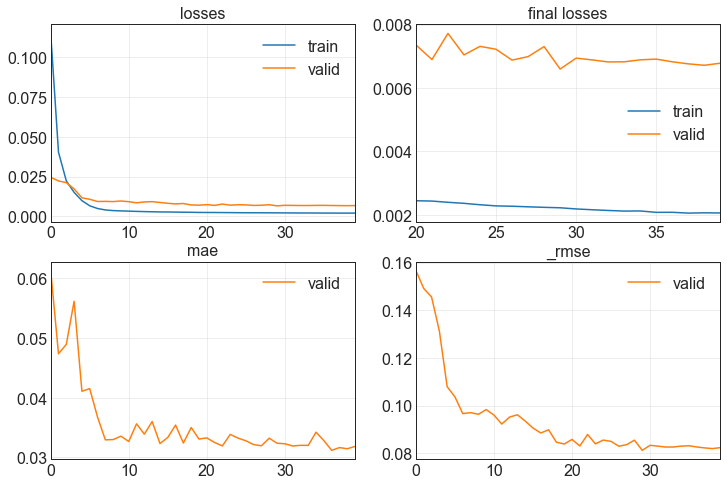

17.086539268493652                                                                                                     
[0.002056136727333069, 0.006783130578696728, 0.03184811770915985, 0.08235976099967957]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 5}
MLP                                                                                                                    
  9%|████▏                                         | 9/100 [03:51<46:47, 30.85s/trial, best loss: 0.006783130578696728]

No improvement since epoch 12: early stopping                                                                          
  9%|████▏                                         | 9/100 [04:04<46:47, 30.85s/trial, best loss: 0.006783130578696728]

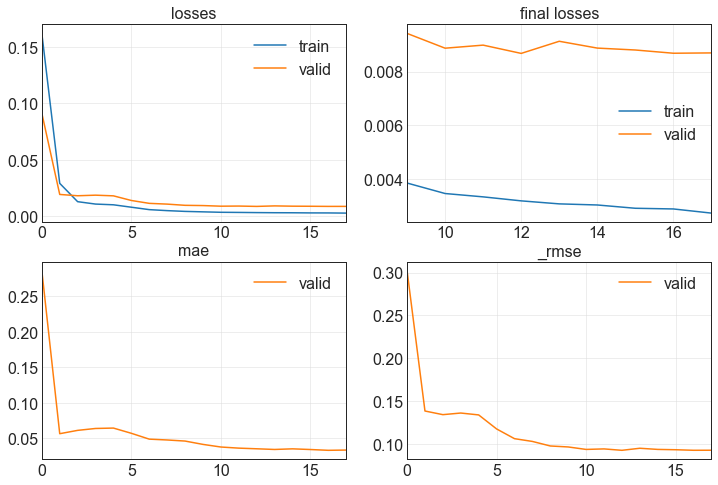

13.479244232177734                                                                                                     
[0.0027367332950234413, 0.008696934208273888, 0.03343956544995308, 0.0932573527097702]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 50, 'fc_dropout': 0.2, 'layers': (200, 200, 200), 'lr': 0.1, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 10%|████▌                                        | 10/100 [04:06<39:06, 26.08s/trial, best loss: 0.006783130578696728]

No improvement since epoch 0: early stopping                                                                           
 10%|████▌                                        | 10/100 [04:13<39:06, 26.08s/trial, best loss: 0.006783130578696728]

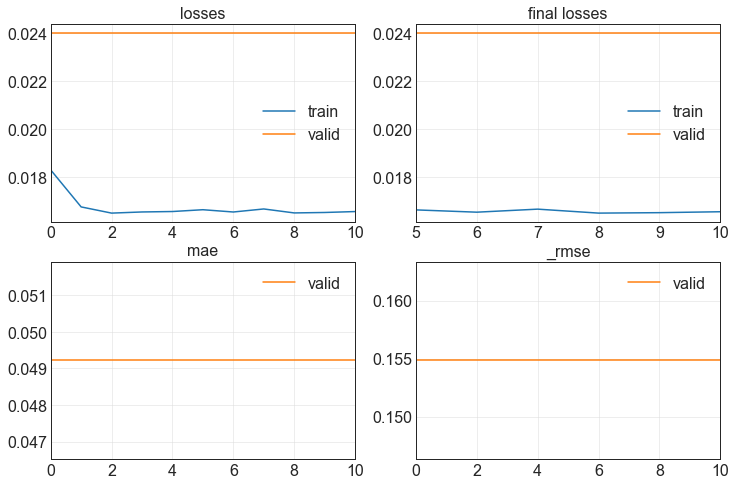

8.11400032043457                                                                                                       
[0.016571948304772377, 0.023976000025868416, 0.049219612032175064, 0.1548418402671814]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 20, 'fc_dropout': 0.5, 'layers': (500, 500, 500), 'lr': 0.01, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 5}
MLP                                                                                                                    
 11%|████▉                                        | 11/100 [04:15<31:19, 21.12s/trial, best loss: 0.006783130578696728]

No improvement since epoch 3: early stopping                                                                           
 11%|████▉                                        | 11/100 [04:36<31:19, 21.12s/trial, best loss: 0.006783130578696728]

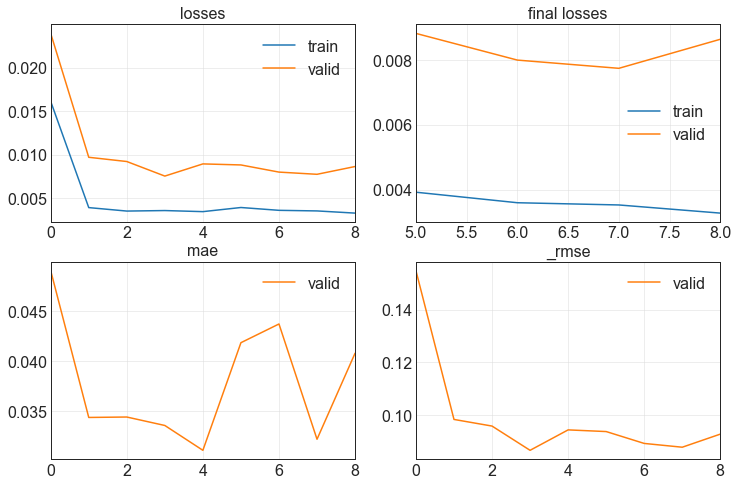

21.637970447540283                                                                                                     
[0.003272546920925379, 0.008630504831671715, 0.04078828543424606, 0.09290049970149994]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 100, 'fc_dropout': 0.5, 'layers': (200, 200, 200), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 5}
MLP                                                                                                                    
 12%|█████▍                                       | 12/100 [04:38<31:49, 21.70s/trial, best loss: 0.006783130578696728]

No improvement since epoch 40: early stopping                                                                          
 12%|█████▍                                       | 12/100 [05:36<31:49, 21.70s/trial, best loss: 0.006783130578696728]

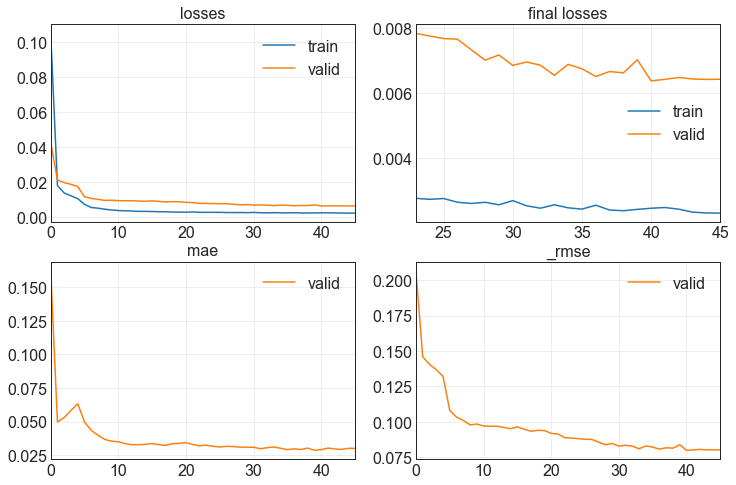

58.43262720108032                                                                                                      
[0.002293286845088005, 0.006422112230211496, 0.03000028431415558, 0.08013808727264404]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 20, 'fc_dropout': 0.2, 'layers': (200, 200, 200), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 5}
MLP                                                                                                                    
 13%|█████▊                                       | 13/100 [05:38<48:03, 33.14s/trial, best loss: 0.006422112230211496]

No improvement since epoch 13: early stopping                                                                          
 13%|█████▊                                       | 13/100 [05:46<48:03, 33.14s/trial, best loss: 0.006422112230211496]

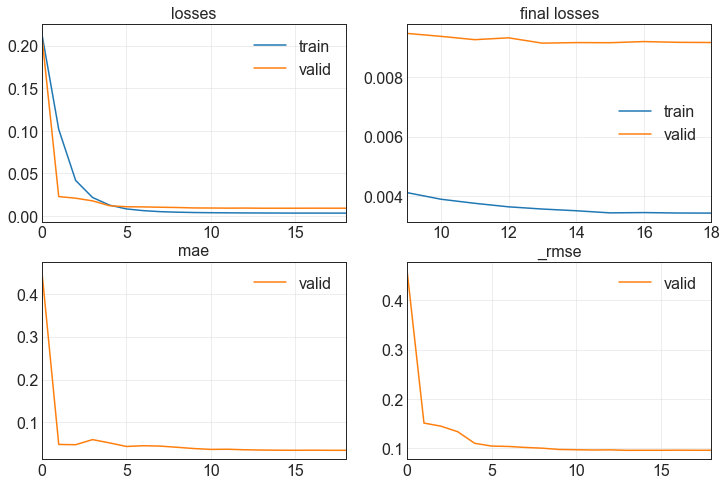

8.165000438690186                                                                                                      
[0.0034198909997940063, 0.009175628423690796, 0.03489527851343155, 0.09578949958086014]                                
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 20, 'fc_dropout': 0.2, 'layers': (100, 100, 100), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 14%|██████▎                                      | 14/100 [05:48<37:23, 26.09s/trial, best loss: 0.006422112230211496]

No improvement since epoch 7: early stopping                                                                           
 14%|██████▎                                      | 14/100 [06:31<37:23, 26.09s/trial, best loss: 0.006422112230211496]

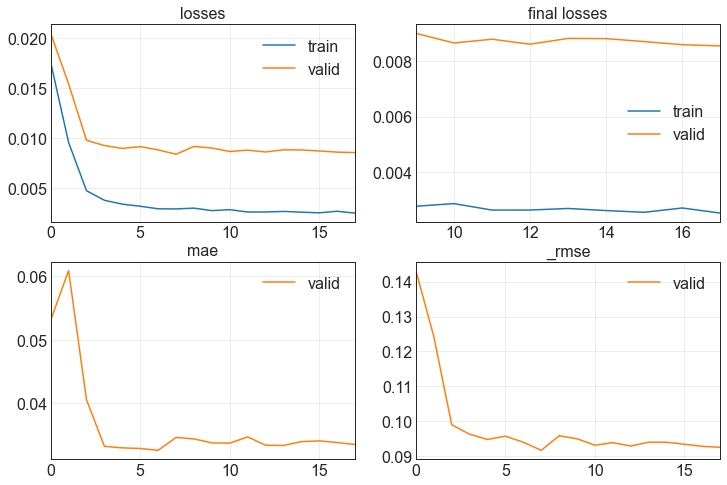

43.39159178733826                                                                                                      
[0.002503389958292246, 0.00856233760714531, 0.03353685885667801, 0.09253290295600891]                                  
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (100, 100, 100), 'lr': 0.1, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 5}
MLP                                                                                                                    
 15%|██████▊                                      | 15/100 [06:32<44:54, 31.70s/trial, best loss: 0.006422112230211496]

No improvement since epoch 0: early stopping                                                                           
 15%|██████▊                                      | 15/100 [06:37<44:54, 31.70s/trial, best loss: 0.006422112230211496]

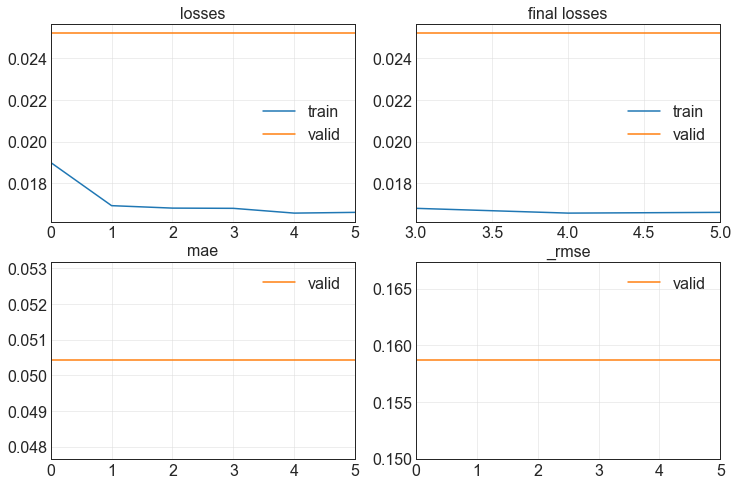

4.736120939254761                                                                                                      
[0.016618778929114342, 0.025174330919981003, 0.0504179447889328, 0.15866421163082123]                                  
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 20, 'fc_dropout': 0.1, 'layers': (200, 200, 200), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 5}
MLP                                                                                                                    
 16%|███████▏                                     | 16/100 [06:39<33:38, 24.03s/trial, best loss: 0.006422112230211496]

No improvement since epoch 9: early stopping                                                                           
 16%|███████▏                                     | 16/100 [07:15<33:38, 24.03s/trial, best loss: 0.006422112230211496]

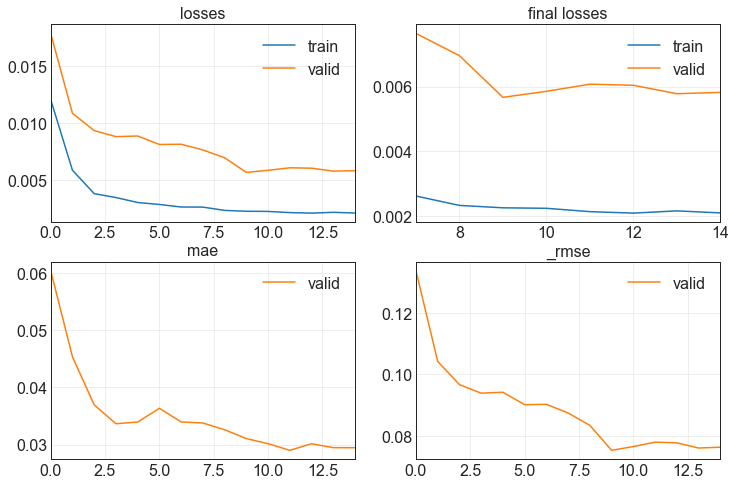

37.11520504951477                                                                                                      
[0.002101945923641324, 0.005823156796395779, 0.029459161683917046, 0.07630960643291473]                                
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 20, 'fc_dropout': 0.5, 'layers': (200, 200, 200), 'lr': 0.01, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 5}
MLP                                                                                                                    
 17%|███████▋                                     | 17/100 [07:17<39:16, 28.39s/trial, best loss: 0.005823156796395779]

No improvement since epoch 3: early stopping                                                                           
 17%|███████▋                                     | 17/100 [07:23<39:16, 28.39s/trial, best loss: 0.005823156796395779]

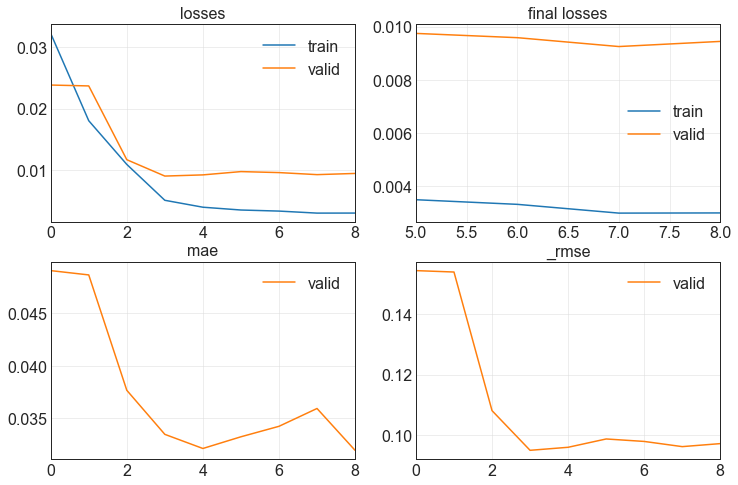

6.593921899795532                                                                                                      
[0.0029978512320667505, 0.009447156451642513, 0.03197373449802399, 0.09719648212194443]                                
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'fc_dropout': 0.5, 'layers': (200, 200, 200), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 5}
MLP                                                                                                                    
 18%|████████                                     | 18/100 [07:25<30:27, 22.28s/trial, best loss: 0.005823156796395779]

No improvement since epoch 35: early stopping                                                                          
 18%|████████                                     | 18/100 [09:02<30:27, 22.28s/trial, best loss: 0.005823156796395779]

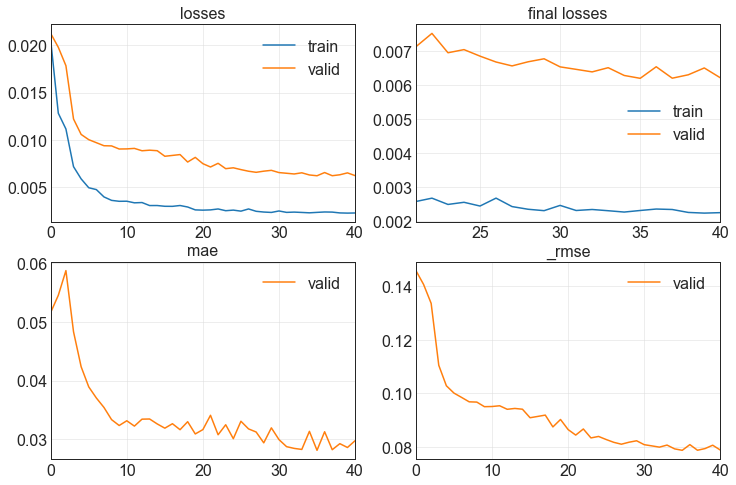

97.32029867172241                                                                                                      
[0.002253442071378231, 0.006213134620338678, 0.029748890548944473, 0.07882344722747803]                                
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 20, 'fc_dropout': 0.2, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 5}
MLP                                                                                                                    
 19%|████████▏                                  | 19/100 [09:04<1:01:02, 45.21s/trial, best loss: 0.005823156796395779]

No improvement since epoch 10: early stopping                                                                          
 19%|████████▏                                  | 19/100 [09:11<1:01:02, 45.21s/trial, best loss: 0.005823156796395779]

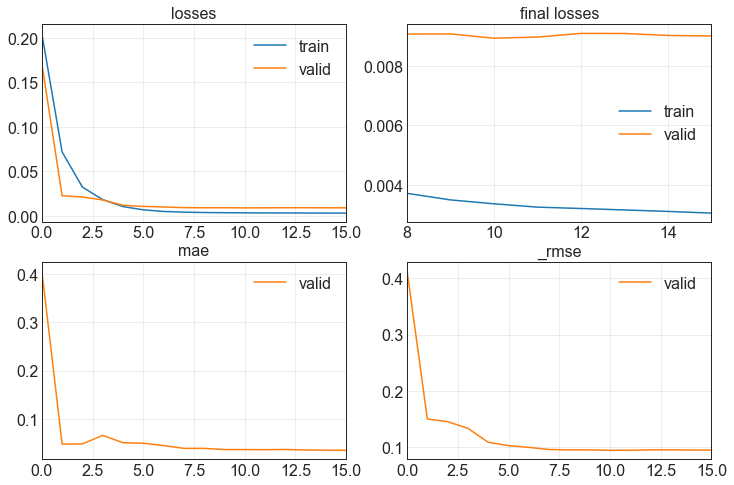

7.037238597869873                                                                                                      
[0.0030560758896172047, 0.009010307490825653, 0.034749966114759445, 0.09492264688014984]                               
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'fc_dropout': 0.5, 'layers': (200, 200, 200), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 5}
MLP                                                                                                                    
 20%|█████████                                    | 20/100 [09:12<45:37, 34.21s/trial, best loss: 0.005823156796395779]

No improvement since epoch 13: early stopping                                                                          
 20%|█████████                                    | 20/100 [09:57<45:37, 34.21s/trial, best loss: 0.005823156796395779]

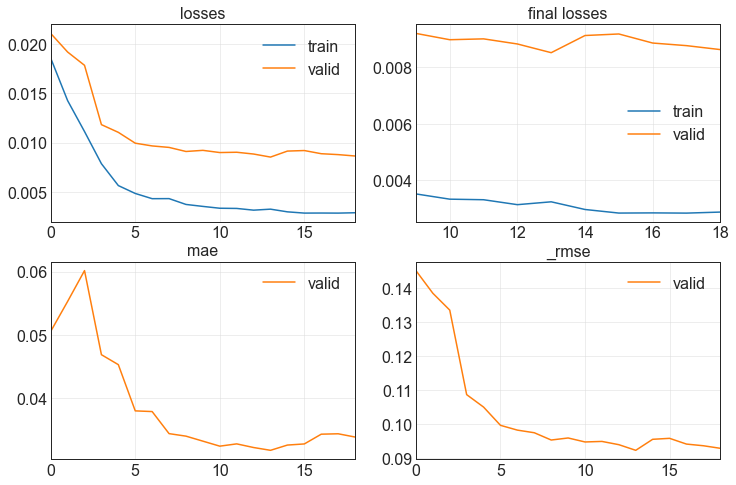

45.385173082351685                                                                                                     
[0.0028745245654135942, 0.008634693920612335, 0.033845167607069016, 0.09292305260896683]                               
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'fc_dropout': 0.5, 'layers': (200, 200, 200), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 5}
MLP                                                                                                                    
 21%|█████████▍                                   | 21/100 [09:59<50:00, 37.98s/trial, best loss: 0.005823156796395779]

No improvement since epoch 30: early stopping                                                                          
 21%|█████████▍                                   | 21/100 [11:25<50:00, 37.98s/trial, best loss: 0.005823156796395779]

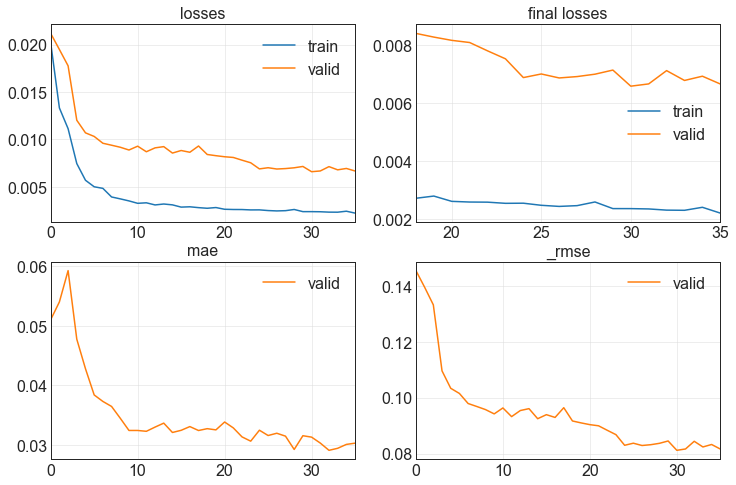

85.8636736869812                                                                                                       
[0.00221594818867743, 0.006659660488367081, 0.030308054760098457, 0.08160673826932907]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'fc_dropout': 0.5, 'layers': (200, 200, 200), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 5}
MLP                                                                                                                    
 22%|█████████▍                                 | 22/100 [11:27<1:08:36, 52.77s/trial, best loss: 0.005823156796395779]

No improvement since epoch 27: early stopping                                                                          
 22%|█████████▍                                 | 22/100 [12:46<1:08:36, 52.77s/trial, best loss: 0.005823156796395779]

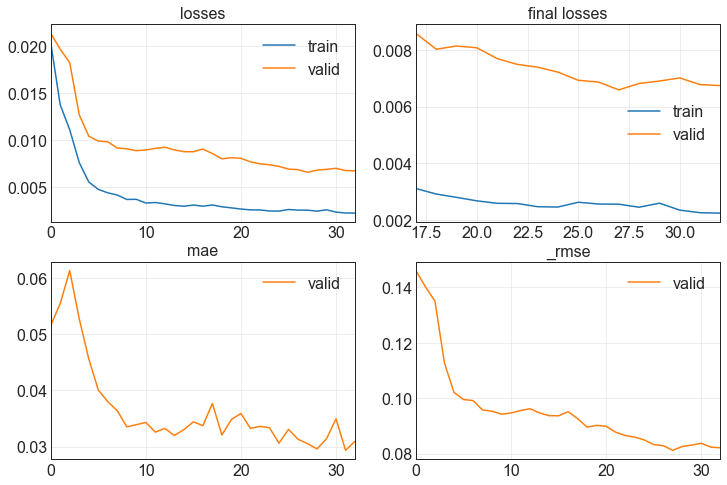

80.36291599273682                                                                                                      
[0.0022461668122559786, 0.006737096700817347, 0.030958587303757668, 0.08207981288433075]                               
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'fc_dropout': 0.5, 'layers': (200, 200, 200), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 5}
MLP                                                                                                                    
 23%|█████████▉                                 | 23/100 [12:48<1:18:53, 61.48s/trial, best loss: 0.005823156796395779]

No improvement since epoch 26: early stopping                                                                          
 23%|█████████▉                                 | 23/100 [14:05<1:18:53, 61.48s/trial, best loss: 0.005823156796395779]

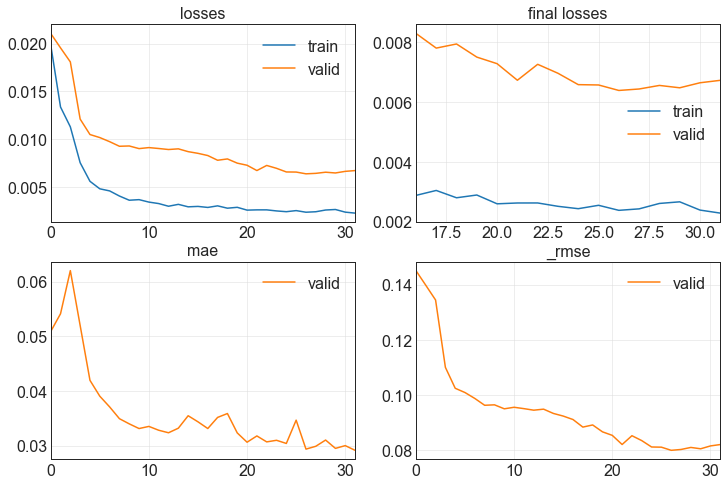

77.22470355033875                                                                                                      
[0.0022834541741758585, 0.006726562976837158, 0.02914425916969776, 0.08201561868190765]                                
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 50, 'fc_dropout': 0.5, 'layers': (200, 200, 200), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 5}
MLP                                                                                                                    
 24%|██████████▎                                | 24/100 [14:07<1:24:23, 66.63s/trial, best loss: 0.005823156796395779]

No improvement since epoch 36: early stopping                                                                          
 24%|██████████▎                                | 24/100 [15:41<1:24:23, 66.63s/trial, best loss: 0.005823156796395779]

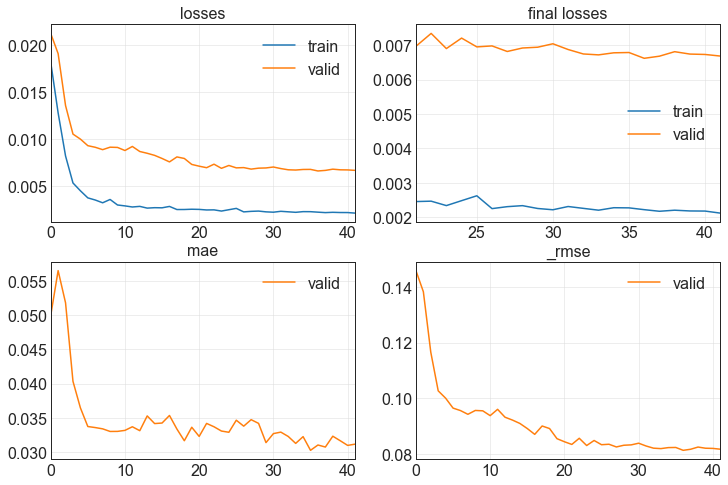

94.67407608032227                                                                                                      
[0.0021250632125884295, 0.006680778693407774, 0.03116249293088913, 0.08173602819442749]                                
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 20, 'fc_dropout': 0.1, 'layers': (200, 200, 200), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 5}
MLP                                                                                                                    
 25%|██████████▊                                | 25/100 [15:43<1:34:19, 75.46s/trial, best loss: 0.005823156796395779]

No improvement since epoch 14: early stopping                                                                          
 25%|██████████▊                                | 25/100 [16:28<1:34:19, 75.46s/trial, best loss: 0.005823156796395779]

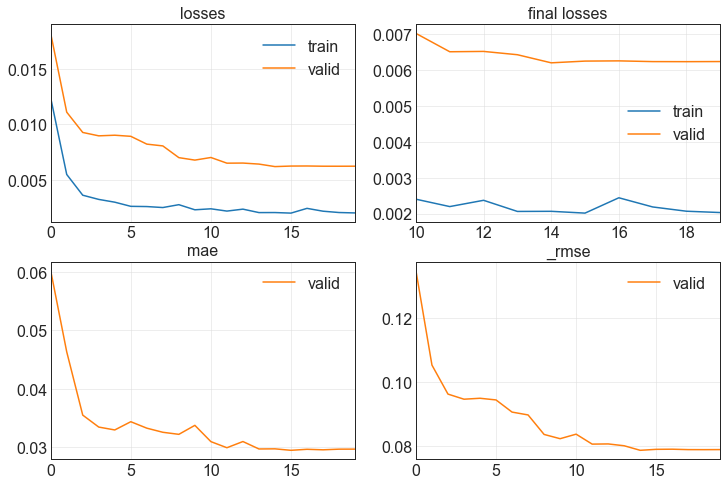

45.387073278427124                                                                                                     
[0.0020295477006584406, 0.00624089827761054, 0.0296668391674757, 0.0789993479847908]                                   
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (100, 100, 100), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 5}
MLP                                                                                                                    
 26%|███████████▏                               | 26/100 [16:30<1:22:27, 66.86s/trial, best loss: 0.005823156796395779]

No improvement since epoch 39: early stopping                                                                          
 26%|███████████▏                               | 26/100 [17:22<1:22:27, 66.86s/trial, best loss: 0.005823156796395779]

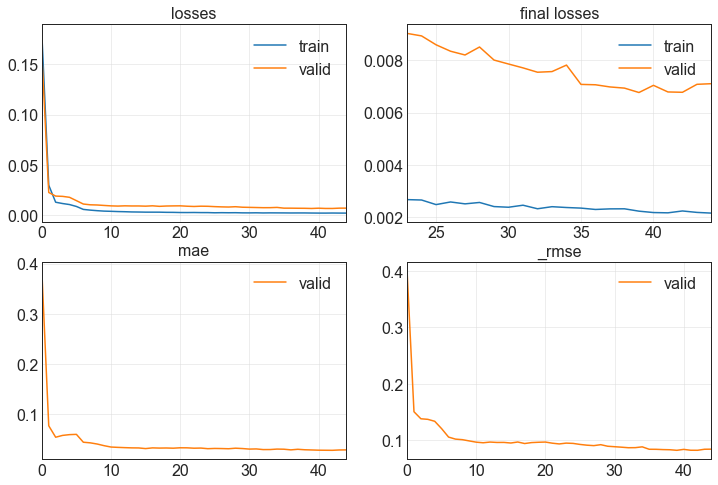

52.594749212265015                                                                                                     
[0.0021609431132674217, 0.0071068815886974335, 0.029553305357694626, 0.08430232107639313]                              
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 20, 'fc_dropout': 0.5, 'layers': (200, 200, 200), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 5}
MLP                                                                                                                    
 27%|███████████▌                               | 27/100 [17:24<1:16:38, 63.00s/trial, best loss: 0.005823156796395779]

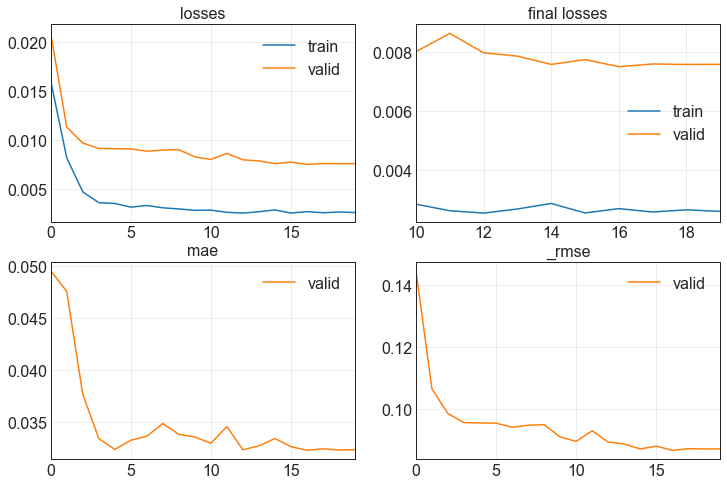

45.55998158454895                                                                                                      
[0.002585685346275568, 0.0075868284329771996, 0.03230711817741394, 0.08710239082574844]                                
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (200, 200, 200), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 5}
MLP                                                                                                                    
 28%|████████████                               | 28/100 [18:11<1:09:49, 58.18s/trial, best loss: 0.005823156796395779]

No improvement since epoch 27: early stopping                                                                          
 28%|████████████                               | 28/100 [19:25<1:09:49, 58.18s/trial, best loss: 0.005823156796395779]

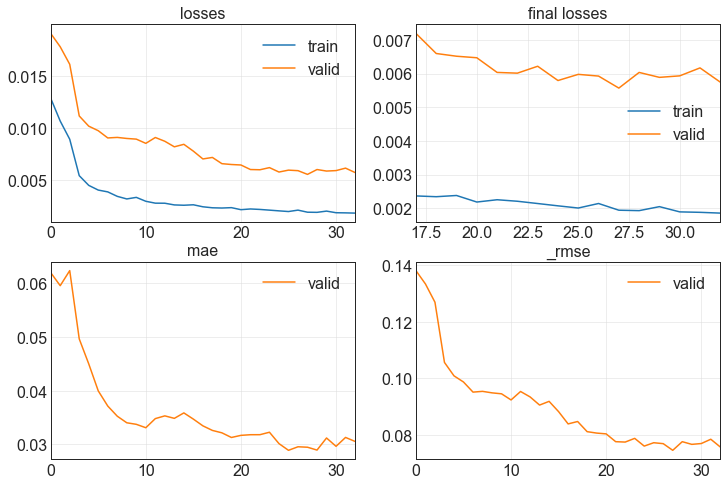

74.95792651176453                                                                                                      
[0.0018547713989391923, 0.005743545480072498, 0.030567606911063194, 0.07578618824481964]                               
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 20, 'fc_dropout': 0.1, 'layers': (200, 200, 200), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 29%|████████████▍                              | 29/100 [19:27<1:15:17, 63.63s/trial, best loss: 0.005743545480072498]

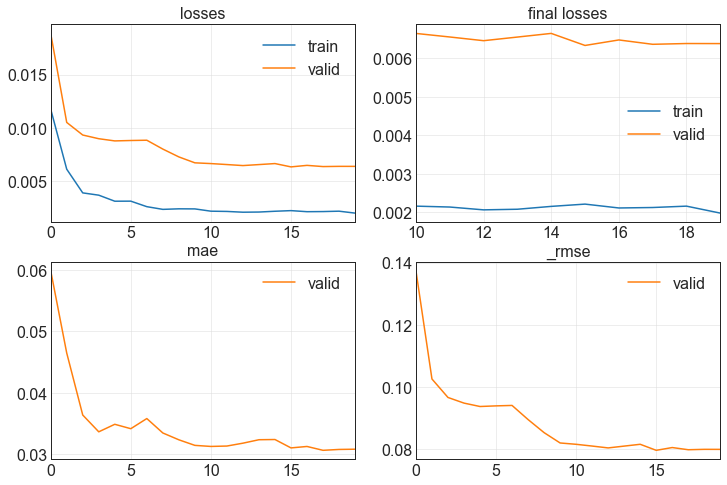

45.33042669296265                                                                                                      
[0.001983083551749587, 0.006378493271768093, 0.030812270939350128, 0.0798654556274414]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 20, 'fc_dropout': 0.1, 'layers': (200, 200, 200), 'lr': 0.1, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 5}
MLP                                                                                                                    
 30%|████████████▉                              | 30/100 [20:14<1:08:19, 58.57s/trial, best loss: 0.005743545480072498]

No improvement since epoch 0: early stopping                                                                           
 30%|████████████▉                              | 30/100 [20:21<1:08:19, 58.57s/trial, best loss: 0.005743545480072498]

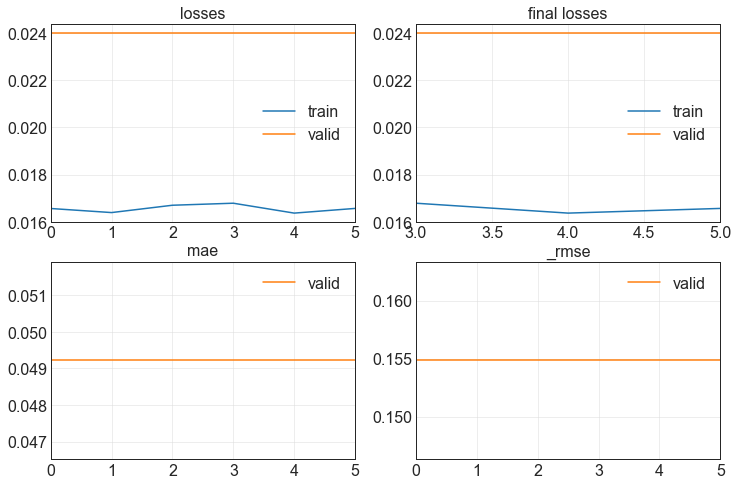

7.442092180252075                                                                                                      
[0.016563327983021736, 0.023976000025868416, 0.049219608306884766, 0.1548418402671814]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (200, 200, 200), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 5}
MLP                                                                                                                    
 31%|█████████████▉                               | 31/100 [20:23<50:11, 43.65s/trial, best loss: 0.005743545480072498]

No improvement since epoch 62: early stopping                                                                          
 31%|█████████████▉                               | 31/100 [20:49<50:11, 43.65s/trial, best loss: 0.005743545480072498]

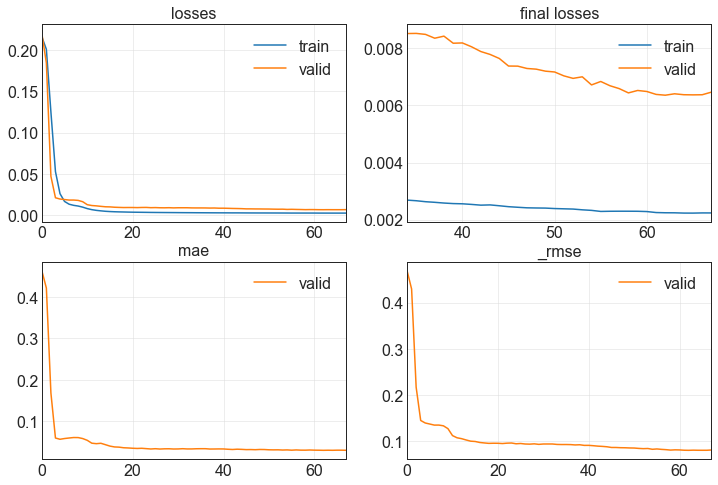

27.077523946762085                                                                                                     
[0.0022363432217389345, 0.006466619670391083, 0.02973993308842182, 0.08041530102491379]                                
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 50, 'fc_dropout': 0.1, 'layers': (100, 100, 100), 'lr': 0.01, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 5}
MLP                                                                                                                    
 32%|██████████████▍                              | 32/100 [20:51<44:18, 39.09s/trial, best loss: 0.005743545480072498]

No improvement since epoch 10: early stopping                                                                          
 32%|██████████████▍                              | 32/100 [21:27<44:18, 39.09s/trial, best loss: 0.005743545480072498]

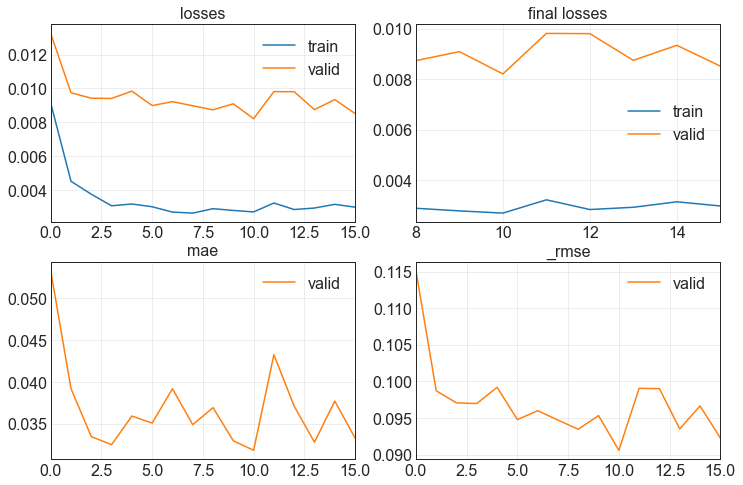

36.02410078048706                                                                                                      
[0.002969979075714946, 0.008513477630913258, 0.03327718377113342, 0.09226849675178528]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 20, 'fc_dropout': 0.1, 'layers': (200, 200, 200), 'lr': 0.1, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 5}
MLP                                                                                                                    
 33%|██████████████▊                              | 33/100 [21:29<43:05, 38.59s/trial, best loss: 0.005743545480072498]

No improvement since epoch 0: early stopping                                                                           
 33%|██████████████▊                              | 33/100 [21:36<43:05, 38.59s/trial, best loss: 0.005743545480072498]

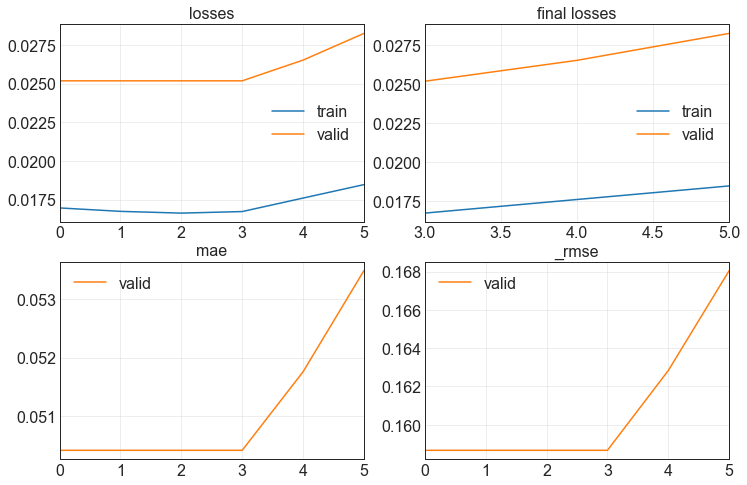

7.435156583786011                                                                                                      
[0.018465708941221237, 0.028239747509360313, 0.05348336696624756, 0.16804687678813934]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 34%|███████████████▎                             | 34/100 [21:37<32:37, 29.66s/trial, best loss: 0.005743545480072498]

No improvement since epoch 25: early stopping                                                                          
 34%|███████████████▎                             | 34/100 [22:58<32:37, 29.66s/trial, best loss: 0.005743545480072498]

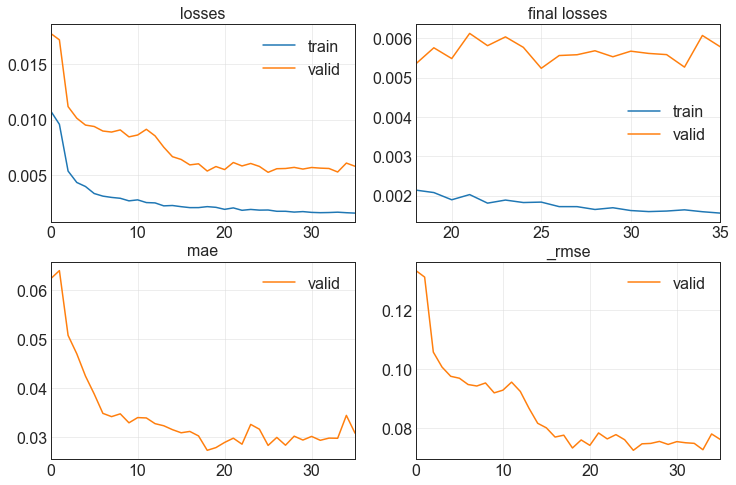

80.83145070075989                                                                                                      
[0.0015544703928753734, 0.005783359054476023, 0.03078327141702175, 0.07604840397834778]                                
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 35%|███████████████▋                             | 35/100 [23:00<49:12, 45.43s/trial, best loss: 0.005743545480072498]

No improvement since epoch 69: early stopping                                                                          
 35%|███████████████▋                             | 35/100 [23:31<49:12, 45.43s/trial, best loss: 0.005743545480072498]

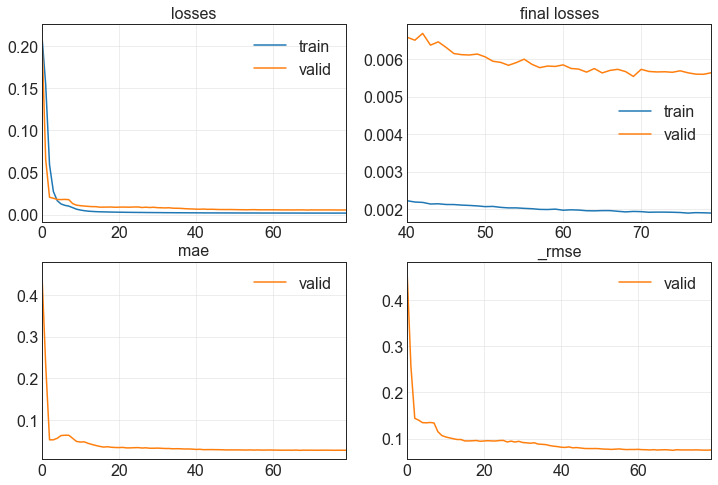

32.17855453491211                                                                                                      
[0.001892178668640554, 0.0056369067169725895, 0.027920061722397804, 0.07507933676242828]                               
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.1, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 36%|███████████████▊                            | 36/100 [23:33<44:40, 41.88s/trial, best loss: 0.0056369067169725895]

No improvement since epoch 0: early stopping                                                                           
 36%|███████████████▊                            | 36/100 [23:38<44:40, 41.88s/trial, best loss: 0.0056369067169725895]

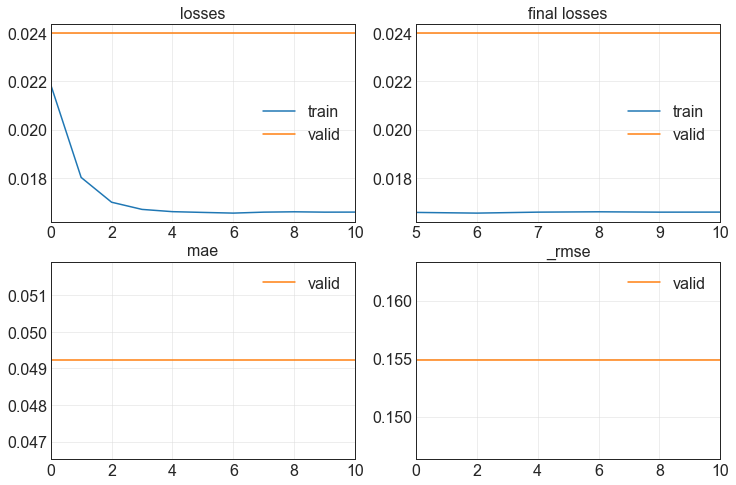

4.767058849334717                                                                                                      
[0.01659335568547249, 0.023975994437932968, 0.049219612032175064, 0.1548418402671814]                                  
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.01, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 37%|████████████████▎                           | 37/100 [23:39<32:43, 31.17s/trial, best loss: 0.0056369067169725895]

No improvement since epoch 50: early stopping                                                                          
 37%|████████████████▎                           | 37/100 [24:05<32:43, 31.17s/trial, best loss: 0.0056369067169725895]

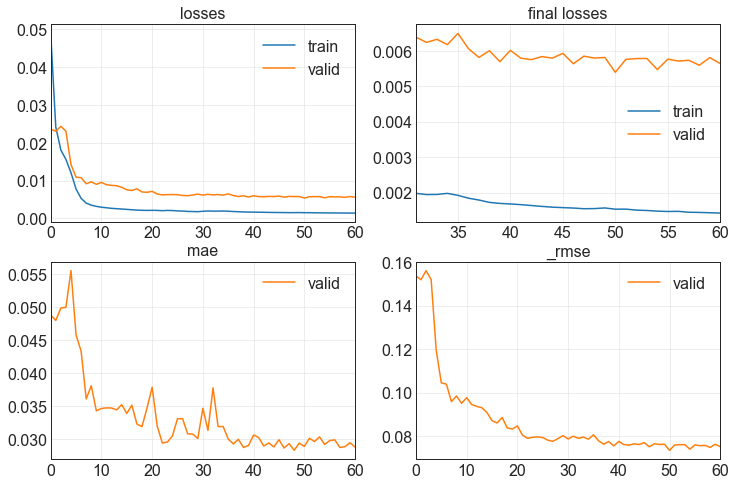

26.544840097427368                                                                                                     
[0.0014212682144716382, 0.005636896472424269, 0.028807714581489563, 0.07507926225662231]                               
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (500, 500, 500), 'lr': 0.01, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 38%|█████████████████                            | 38/100 [24:07<31:12, 30.20s/trial, best loss: 0.005636896472424269]

No improvement since epoch 47: early stopping                                                                          
 38%|█████████████████                            | 38/100 [24:30<31:12, 30.20s/trial, best loss: 0.005636896472424269]

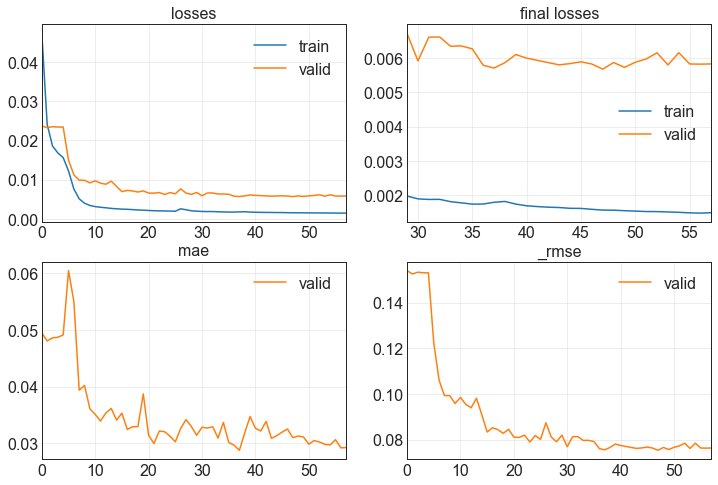

23.43860697746277                                                                                                      
[0.0014900611713528633, 0.0058303894475102425, 0.02928486466407776, 0.07635697722434998]                               
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.01, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 39%|█████████████████▌                           | 39/100 [24:32<29:04, 28.60s/trial, best loss: 0.005636896472424269]

No improvement since epoch 43: early stopping                                                                          
 39%|█████████████████▌                           | 39/100 [24:54<29:04, 28.60s/trial, best loss: 0.005636896472424269]

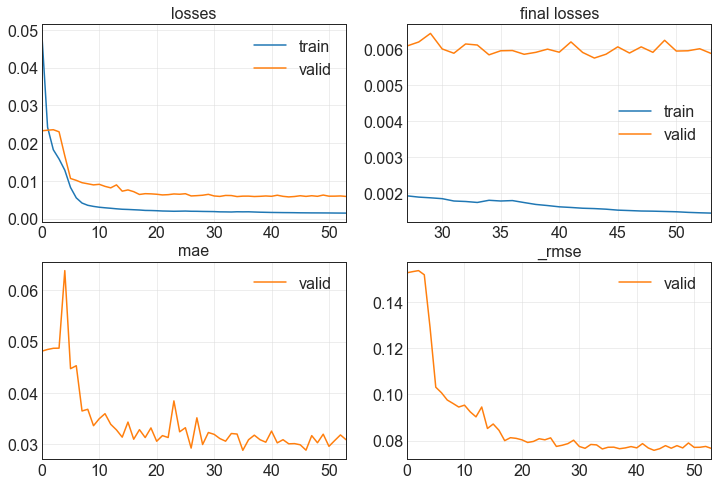

22.46692991256714                                                                                                      
[0.0014543751021847129, 0.005871146451681852, 0.030816538259387016, 0.07662340253591537]                               
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 50, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.01, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 40%|██████████████████                           | 40/100 [24:56<27:11, 27.19s/trial, best loss: 0.005636896472424269]

No improvement since epoch 33: early stopping                                                                          
 40%|██████████████████                           | 40/100 [25:14<27:11, 27.19s/trial, best loss: 0.005636896472424269]

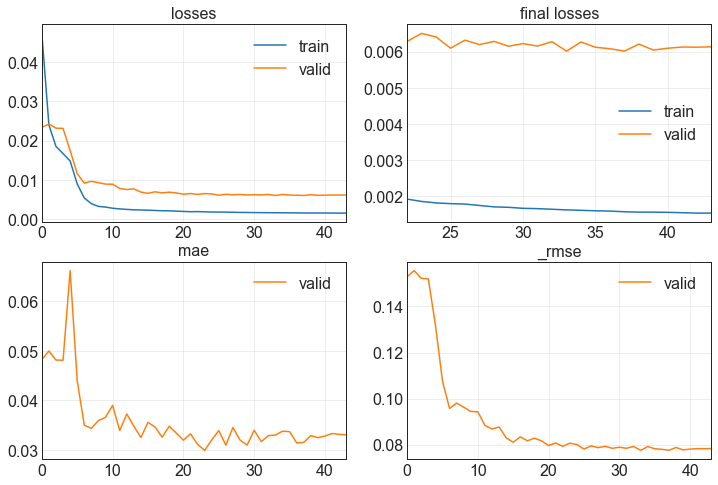

18.44730520248413                                                                                                      
[0.0015249401330947876, 0.006134878844022751, 0.03306537866592407, 0.07832546532154083]                                
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.01, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 41%|██████████████████▍                          | 41/100 [25:16<24:35, 25.00s/trial, best loss: 0.005636896472424269]

No improvement since epoch 28: early stopping                                                                          
 41%|██████████████████▍                          | 41/100 [25:32<24:35, 25.00s/trial, best loss: 0.005636896472424269]

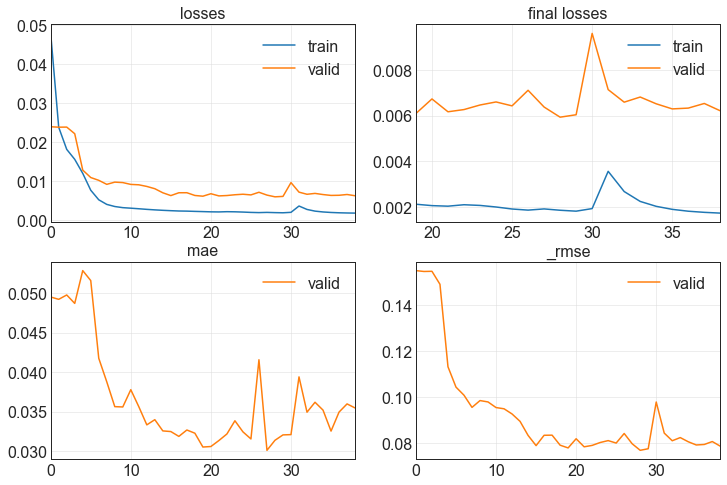

16.1452157497406                                                                                                       
[0.0017476581269875169, 0.006212284788489342, 0.035455163568258286, 0.07881804555654526]                               
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (500, 500, 500), 'lr': 0.01, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 42%|██████████████████▉                          | 42/100 [25:34<22:00, 22.77s/trial, best loss: 0.005636896472424269]

No improvement since epoch 39: early stopping                                                                          
 42%|██████████████████▉                          | 42/100 [25:54<22:00, 22.77s/trial, best loss: 0.005636896472424269]

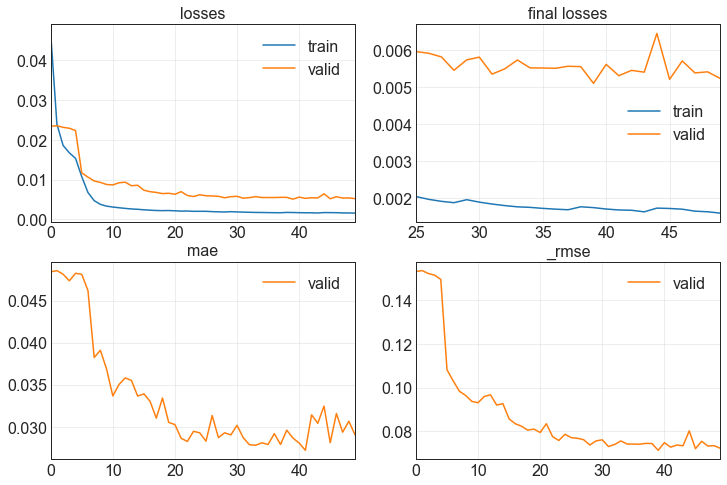

20.995429277420044                                                                                                     
[0.00159663544036448, 0.005229856353253126, 0.029026972129940987, 0.07231774926185608]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 50, 'fc_dropout': 0.2, 'layers': (500, 500, 500), 'lr': 0.01, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 43%|███████████████████▎                         | 43/100 [25:56<21:31, 22.66s/trial, best loss: 0.005229856353253126]

No improvement since epoch 35: early stopping                                                                          
 43%|███████████████████▎                         | 43/100 [26:17<21:31, 22.66s/trial, best loss: 0.005229856353253126]

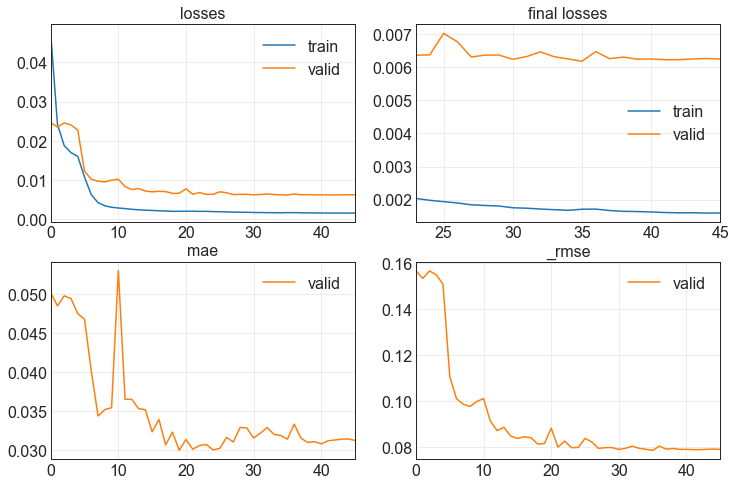

21.027976989746094                                                                                                     
[0.001597992260940373, 0.006249603815376759, 0.031234988942742348, 0.07905443757772446]                                
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (500, 500, 500), 'lr': 0.01, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 44%|███████████████████▊                         | 44/100 [26:18<21:05, 22.60s/trial, best loss: 0.005229856353253126]

No improvement since epoch 28: early stopping                                                                          
 44%|███████████████████▊                         | 44/100 [26:35<21:05, 22.60s/trial, best loss: 0.005229856353253126]

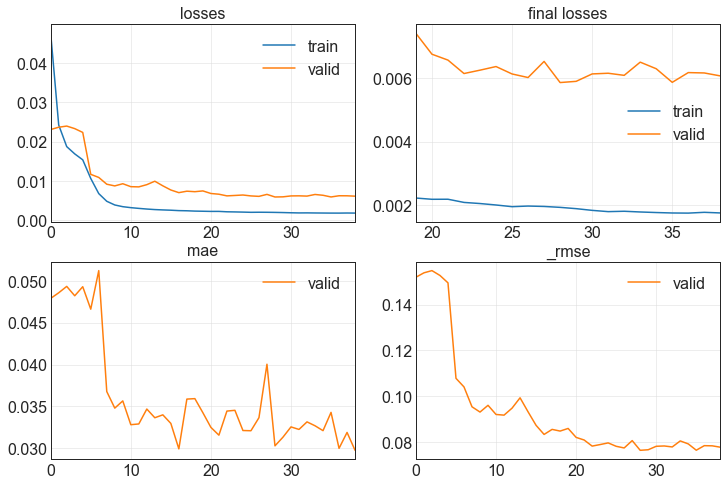

16.71627116203308                                                                                                      
[0.001756137702614069, 0.006071881391108036, 0.02975538559257984, 0.0779222771525383]                                  
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (500, 500, 500), 'lr': 0.01, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 45%|████████████████████▎                        | 45/100 [26:37<19:30, 21.28s/trial, best loss: 0.005229856353253126]

No improvement since epoch 20: early stopping                                                                          
 45%|████████████████████▎                        | 45/100 [26:49<19:30, 21.28s/trial, best loss: 0.005229856353253126]

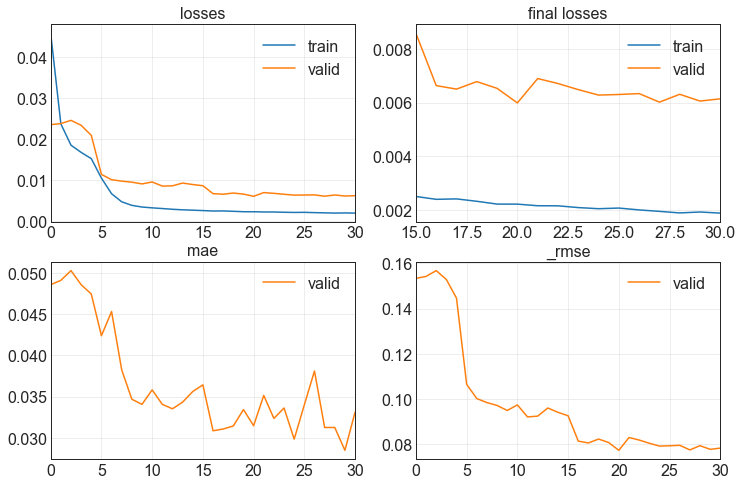

12.874302625656128                                                                                                     
[0.0018780321115627885, 0.0061404029838740826, 0.033115386962890625, 0.07836072146892548]                              
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (500, 500, 500), 'lr': 0.01, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 46%|████████████████████▋                        | 46/100 [26:51<17:16, 19.19s/trial, best loss: 0.005229856353253126]

No improvement since epoch 19: early stopping                                                                          
 46%|████████████████████▋                        | 46/100 [27:12<17:16, 19.19s/trial, best loss: 0.005229856353253126]

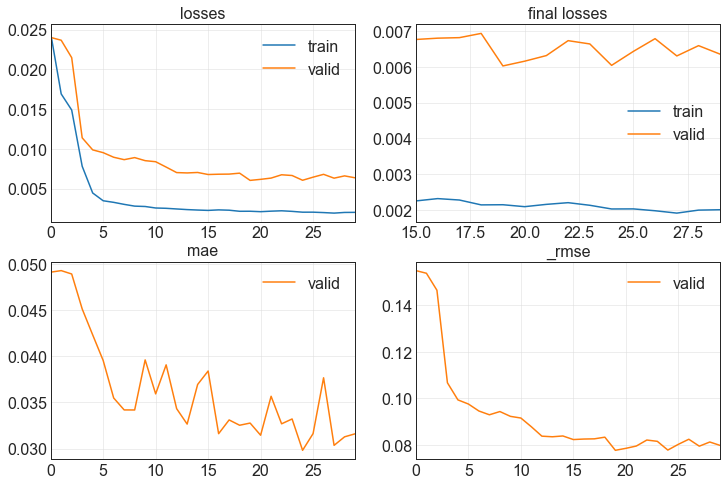

21.336902379989624                                                                                                     
[0.0020057056099176407, 0.00635528052225709, 0.031598757952451706, 0.07972001284360886]                                
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 50, 'fc_dropout': 0.2, 'layers': (500, 500, 500), 'lr': 0.01, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 47%|█████████████████████▏                       | 47/100 [27:14<17:53, 20.26s/trial, best loss: 0.005229856353253126]

No improvement since epoch 24: early stopping                                                                          
 47%|█████████████████████▏                       | 47/100 [27:27<17:53, 20.26s/trial, best loss: 0.005229856353253126]

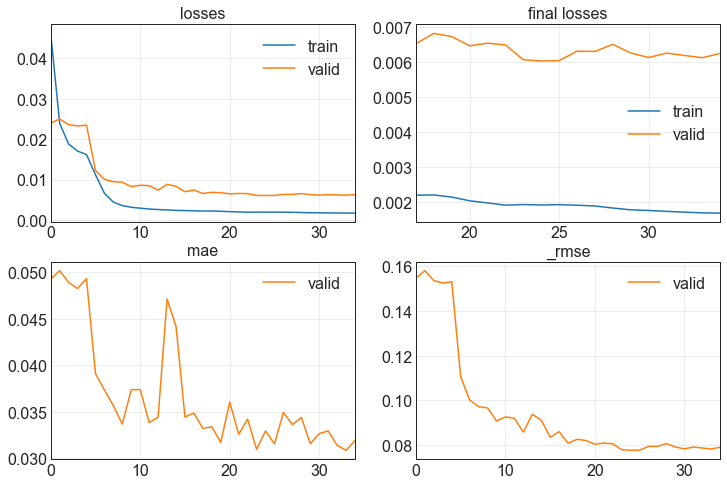

14.166256666183472                                                                                                     
[0.0016852447297424078, 0.006258611101657152, 0.03193245828151703, 0.07911138236522675]                                
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (500, 500, 500), 'lr': 0.01, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 48%|█████████████████████▌                       | 48/100 [27:29<16:19, 18.84s/trial, best loss: 0.005229856353253126]

No improvement since epoch 45: early stopping                                                                          
 48%|█████████████████████▌                       | 48/100 [27:51<16:19, 18.84s/trial, best loss: 0.005229856353253126]

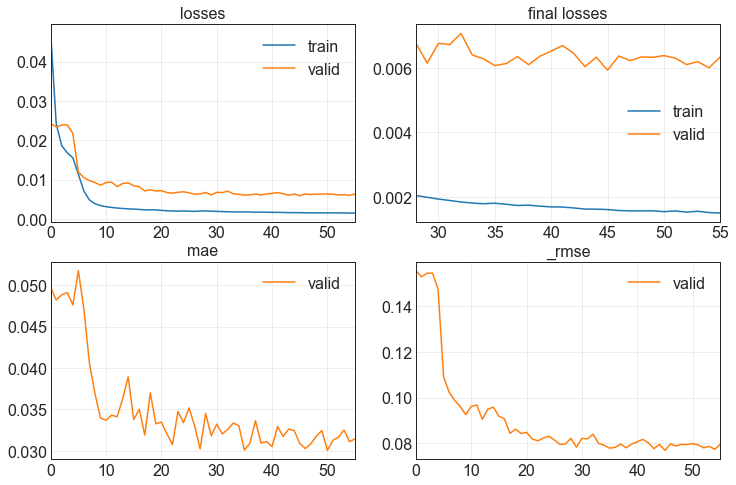

22.52573585510254                                                                                                      
[0.001498461700975895, 0.0063381739892065525, 0.03143853694200516, 0.07961264997720718]                                
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (100, 100, 100), 'lr': 0.01, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 49%|██████████████████████                       | 49/100 [27:53<17:18, 20.37s/trial, best loss: 0.005229856353253126]

No improvement since epoch 22: early stopping                                                                          
 49%|██████████████████████                       | 49/100 [28:15<17:18, 20.37s/trial, best loss: 0.005229856353253126]

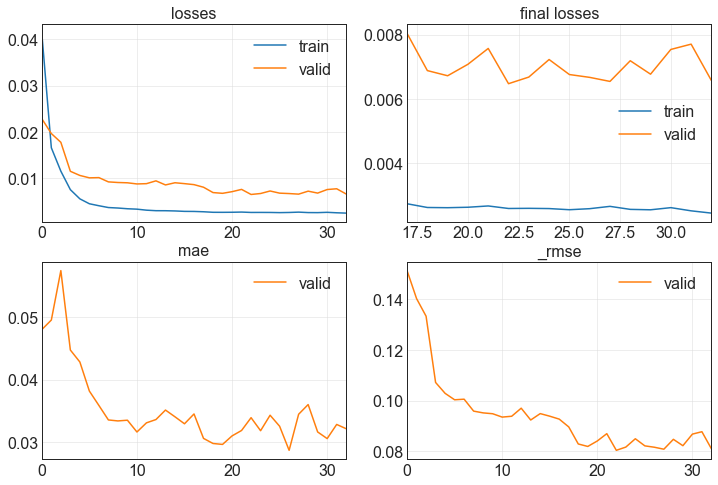

22.680283546447754                                                                                                     
[0.002442798810079694, 0.006569365970790386, 0.03212948888540268, 0.08105162531137466]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (500, 500, 500), 'lr': 0.01, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 50%|██████████████████████▌                      | 50/100 [28:17<17:53, 21.48s/trial, best loss: 0.005229856353253126]

No improvement since epoch 14: early stopping                                                                          
 50%|██████████████████████▌                      | 50/100 [28:50<17:53, 21.48s/trial, best loss: 0.005229856353253126]

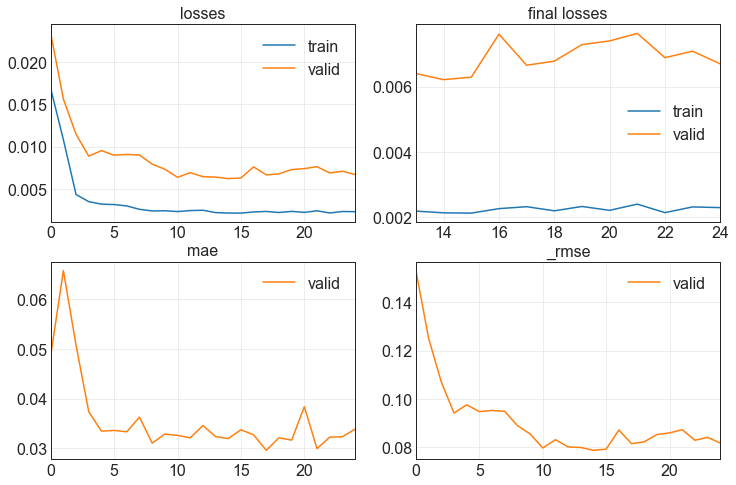

33.15572667121887                                                                                                      
[0.0022972000297158957, 0.006694091018289328, 0.03384345769882202, 0.08181741833686829]                                
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 50, 'fc_dropout': 0.2, 'layers': (500, 500, 500), 'lr': 0.01, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 51%|██████████████████████▉                      | 51/100 [28:52<20:46, 25.43s/trial, best loss: 0.005229856353253126]

No improvement since epoch 33: early stopping                                                                          
 51%|██████████████████████▉                      | 51/100 [29:11<20:46, 25.43s/trial, best loss: 0.005229856353253126]

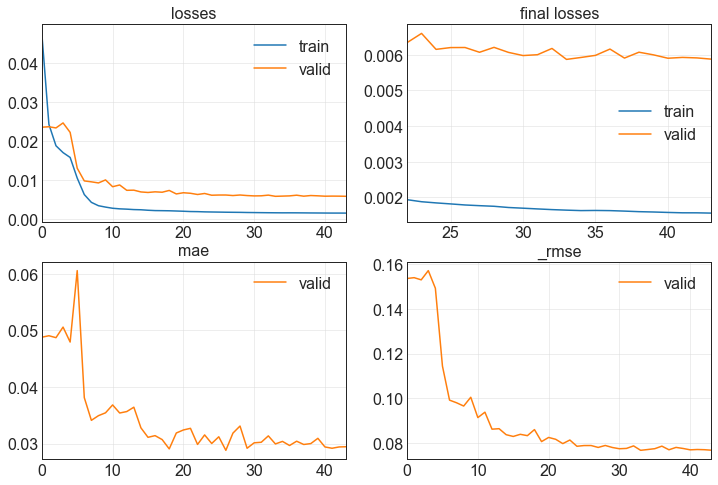

19.67471981048584                                                                                                      
[0.0015615997835993767, 0.005876374430954456, 0.029428379610180855, 0.07665751129388809]                               
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (100, 100, 100), 'lr': 0.1, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 52%|███████████████████████▍                     | 52/100 [29:13<19:19, 24.16s/trial, best loss: 0.005229856353253126]

No improvement since epoch 1: early stopping                                                                           
 52%|███████████████████████▍                     | 52/100 [29:18<19:19, 24.16s/trial, best loss: 0.005229856353253126]

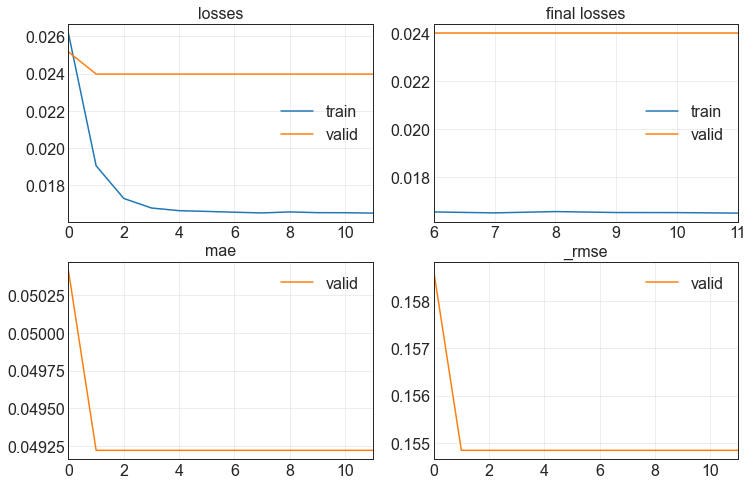

5.372189998626709                                                                                                      
[0.01651790551841259, 0.023975994437932968, 0.049219612032175064, 0.1548418402671814]                                  
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (500, 500, 500), 'lr': 0.01, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 53%|███████████████████████▊                     | 53/100 [29:20<14:51, 18.98s/trial, best loss: 0.005229856353253126]

No improvement since epoch 38: early stopping                                                                          
 53%|███████████████████████▊                     | 53/100 [29:57<14:51, 18.98s/trial, best loss: 0.005229856353253126]

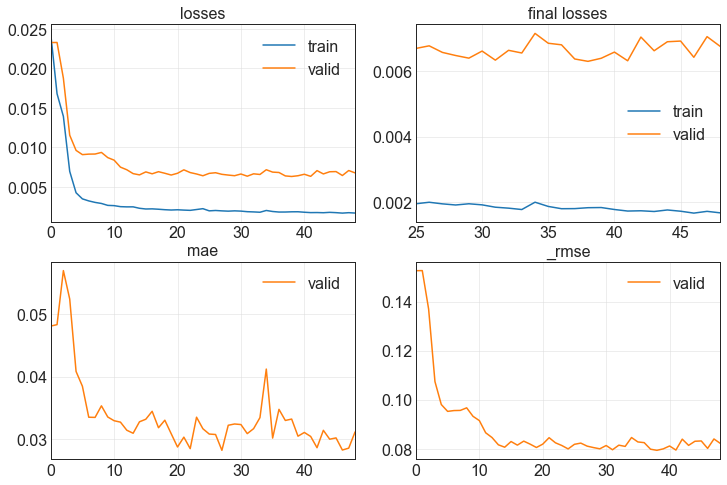

37.524619579315186                                                                                                     
[0.001665488351136446, 0.006754986476153135, 0.031096382066607475, 0.08218873292207718]                                
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (500, 500, 500), 'lr': 0.01, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 54%|████████████████████████▎                    | 54/100 [29:59<19:09, 24.99s/trial, best loss: 0.005229856353253126]

No improvement since epoch 22: early stopping                                                                          
 54%|████████████████████████▎                    | 54/100 [30:13<19:09, 24.99s/trial, best loss: 0.005229856353253126]

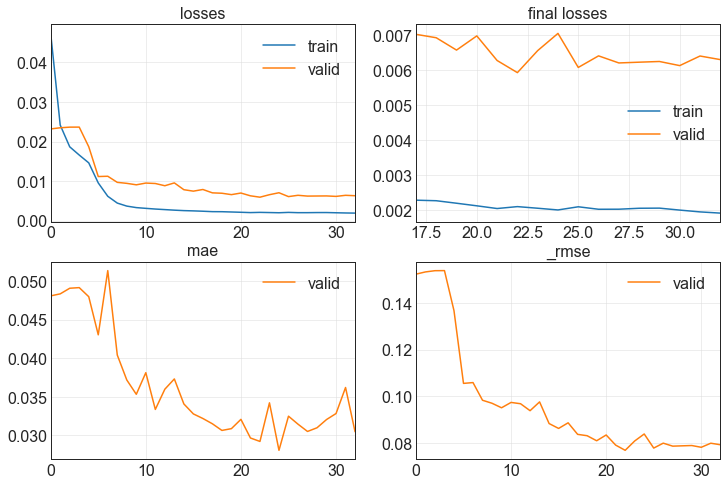

14.733943700790405                                                                                                     
[0.001904736622236669, 0.006302231922745705, 0.030476272106170654, 0.07938659191131592]                                
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 50, 'fc_dropout': 0.2, 'layers': (100, 100, 100), 'lr': 0.01, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 55%|████████████████████████▊                    | 55/100 [30:15<16:46, 22.36s/trial, best loss: 0.005229856353253126]

No improvement since epoch 11: early stopping                                                                          
 55%|████████████████████████▊                    | 55/100 [30:43<16:46, 22.36s/trial, best loss: 0.005229856353253126]

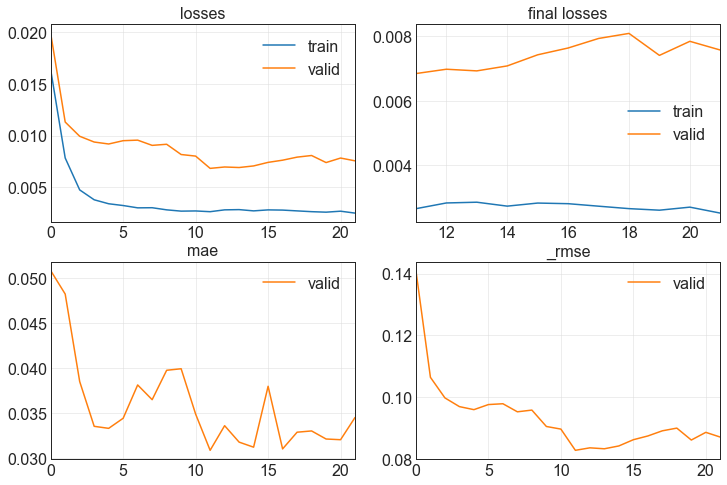

28.07220697402954                                                                                                      
[0.002525836694985628, 0.007572570815682411, 0.03450887277722359, 0.08702051639556885]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'fc_dropout': 0.5, 'layers': (500, 500, 500), 'lr': 0.1, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 56%|█████████████████████████▏                   | 56/100 [30:45<17:58, 24.51s/trial, best loss: 0.005229856353253126]

No improvement since epoch 0: early stopping                                                                           
 56%|█████████████████████████▏                   | 56/100 [30:49<17:58, 24.51s/trial, best loss: 0.005229856353253126]

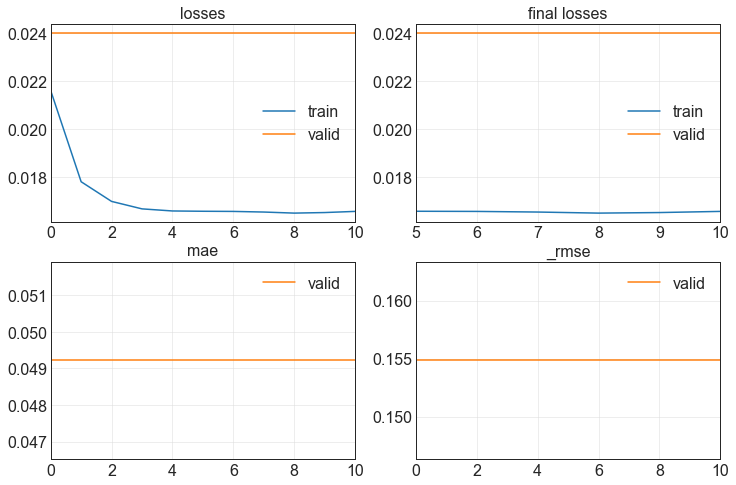

5.1957268714904785                                                                                                     
[0.01659298874437809, 0.023975994437932968, 0.049219612032175064, 0.1548418402671814]                                  
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (500, 500, 500), 'lr': 0.01, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 57%|█████████████████████████▋                   | 57/100 [30:51<13:43, 19.14s/trial, best loss: 0.005229856353253126]

No improvement since epoch 19: early stopping                                                                          
 57%|█████████████████████████▋                   | 57/100 [31:14<13:43, 19.14s/trial, best loss: 0.005229856353253126]

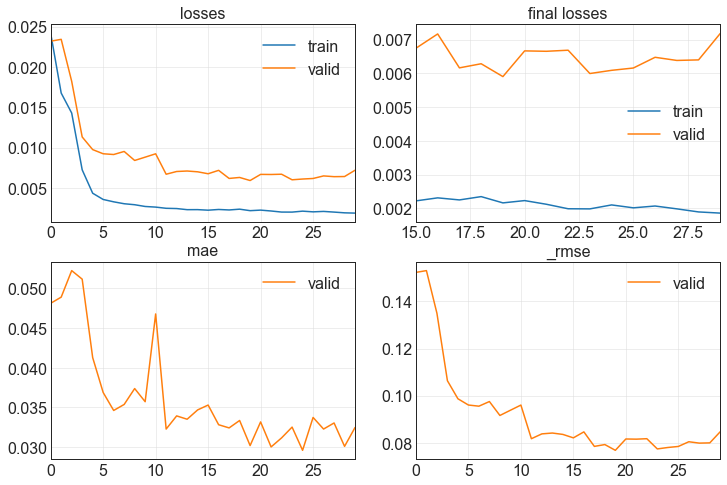

23.15042805671692                                                                                                      
[0.0018619248876348138, 0.007183244917541742, 0.032488029450178146, 0.08475402742624283]                               
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.01, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 58%|██████████████████████████                   | 58/100 [31:16<14:32, 20.78s/trial, best loss: 0.005229856353253126]

No improvement since epoch 35: early stopping                                                                          
 58%|██████████████████████████                   | 58/100 [31:36<14:32, 20.78s/trial, best loss: 0.005229856353253126]

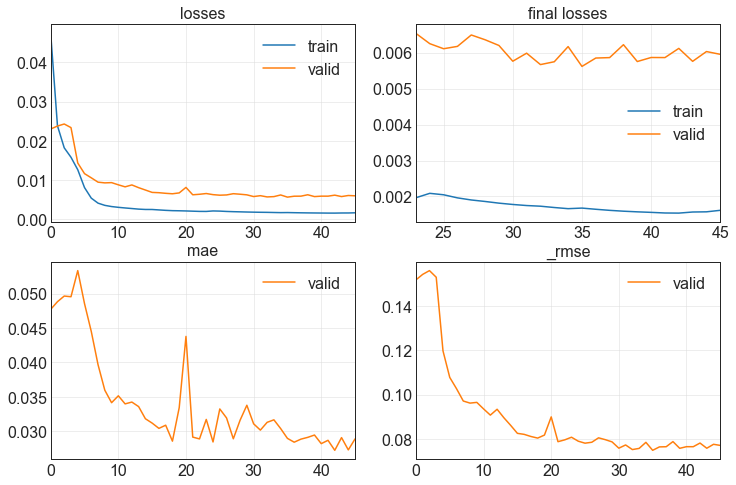

20.00191593170166                                                                                                      
[0.001615198329091072, 0.005954865366220474, 0.02888871356844902, 0.07716777175664902]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 50, 'fc_dropout': 0.5, 'layers': (100, 100, 100), 'lr': 0.1, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 59%|██████████████████████████▌                  | 59/100 [31:38<14:21, 21.01s/trial, best loss: 0.005229856353253126]

No improvement since epoch 0: early stopping                                                                           
 59%|██████████████████████████▌                  | 59/100 [31:52<14:21, 21.01s/trial, best loss: 0.005229856353253126]

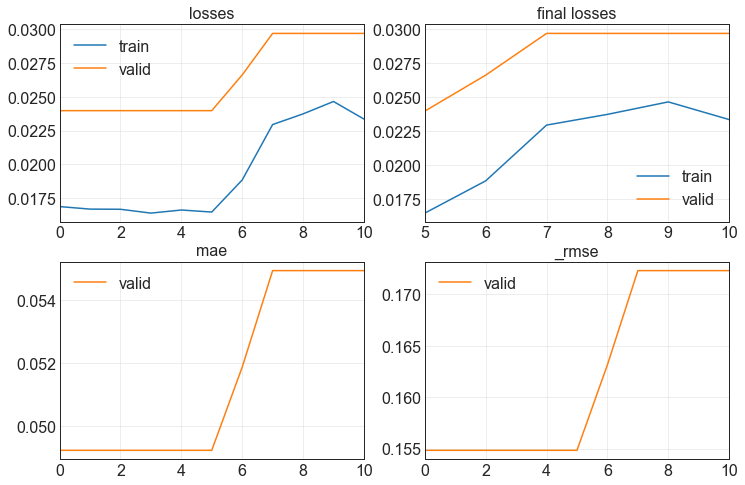

14.668440580368042                                                                                                     
[0.023353852331638336, 0.029690628871321678, 0.05493423715233803, 0.17230969667434692]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 20, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.01, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 60%|███████████████████████████                  | 60/100 [31:54<13:01, 19.55s/trial, best loss: 0.005229856353253126]

No improvement since epoch 1: early stopping                                                                           
 60%|███████████████████████████                  | 60/100 [31:59<13:01, 19.55s/trial, best loss: 0.005229856353253126]

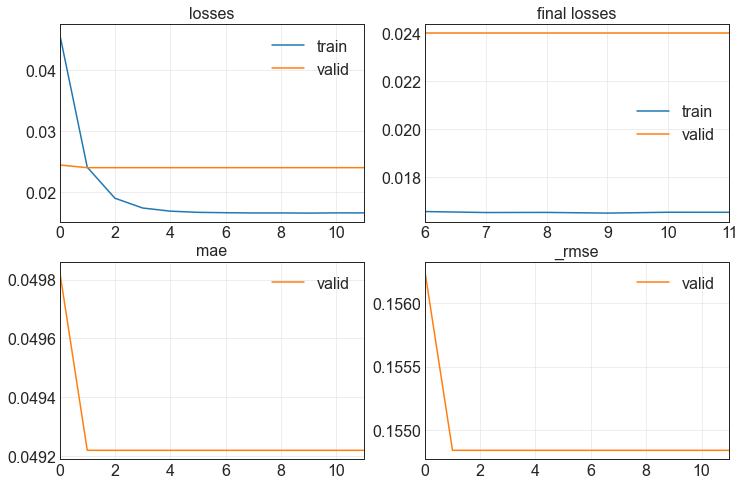

5.617001533508301                                                                                                      
[0.016542762517929077, 0.023975994437932968, 0.049219612032175064, 0.1548418402671814]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (500, 500, 500), 'lr': 0.01, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 61%|███████████████████████████▍                 | 61/100 [32:01<10:16, 15.81s/trial, best loss: 0.005229856353253126]

No improvement since epoch 37: early stopping                                                                          
 61%|███████████████████████████▍                 | 61/100 [32:37<10:16, 15.81s/trial, best loss: 0.005229856353253126]

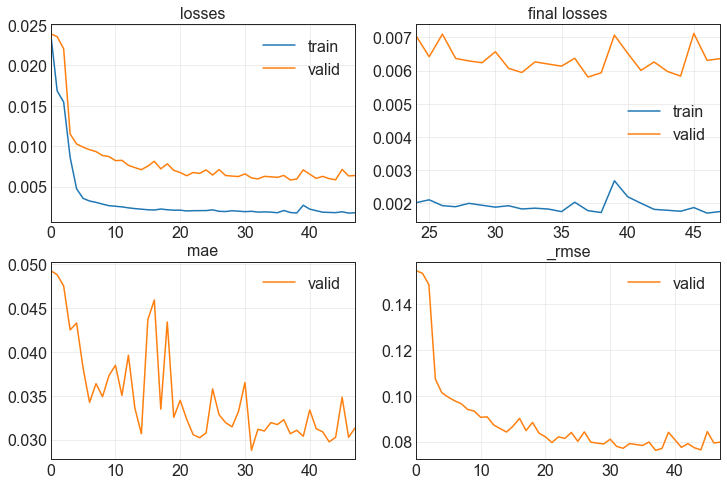

36.340827226638794                                                                                                     
[0.0017578140832483768, 0.006361756008118391, 0.031325552612543106, 0.0797606110572815]                                
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'fc_dropout': 0.5, 'layers': (100, 100, 100), 'lr': 0.01, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 62%|███████████████████████████▉                 | 62/100 [32:39<14:12, 22.43s/trial, best loss: 0.005229856353253126]

No improvement since epoch 72: early stopping                                                                          
 62%|███████████████████████████▉                 | 62/100 [33:14<14:12, 22.43s/trial, best loss: 0.005229856353253126]

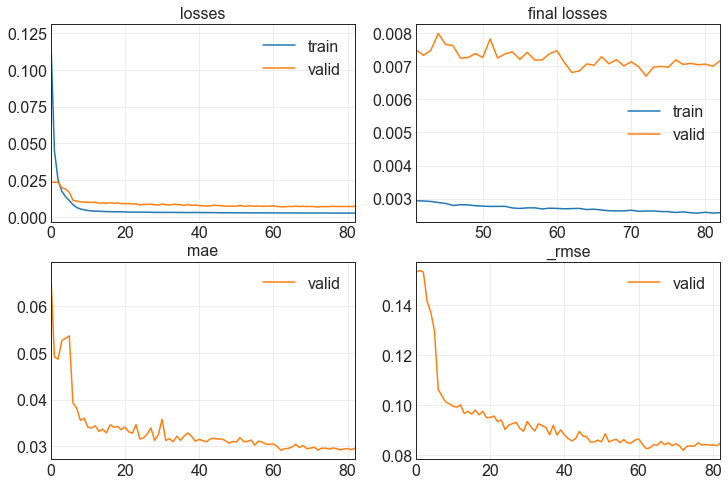

35.537497997283936                                                                                                     
[0.002571703400462866, 0.007180259563028812, 0.029579754918813705, 0.0847364217042923]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 20, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.1, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 63%|████████████████████████████▎                | 63/100 [33:16<16:31, 26.81s/trial, best loss: 0.005229856353253126]

No improvement since epoch 0: early stopping                                                                           
 63%|████████████████████████████▎                | 63/100 [33:20<16:31, 26.81s/trial, best loss: 0.005229856353253126]

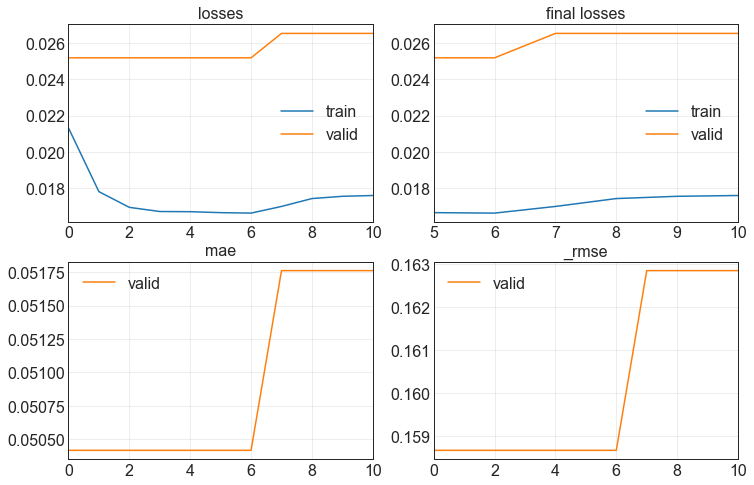

4.982163190841675                                                                                                      
[0.017598412930965424, 0.026517238467931747, 0.051760848611593246, 0.16284114122390747]                                
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.01, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 64%|████████████████████████████▊                | 64/100 [33:22<12:25, 20.70s/trial, best loss: 0.005229856353253126]

No improvement since epoch 20: early stopping                                                                          
 64%|████████████████████████████▊                | 64/100 [34:03<12:25, 20.70s/trial, best loss: 0.005229856353253126]

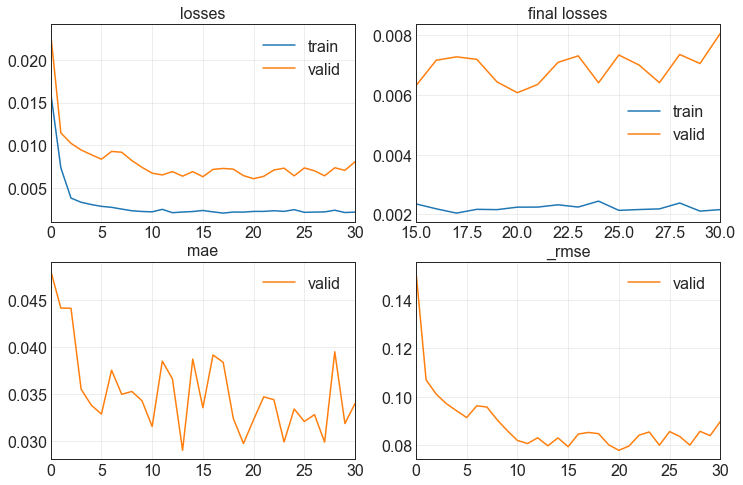

41.80116605758667                                                                                                      
[0.002162582939490676, 0.008066312409937382, 0.034040097147226334, 0.08981265127658844]                                
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 65%|█████████████████████████████▎               | 65/100 [34:05<16:01, 27.46s/trial, best loss: 0.005229856353253126]

No improvement since epoch 65: early stopping                                                                          
 65%|█████████████████████████████▎               | 65/100 [34:38<16:01, 27.46s/trial, best loss: 0.005229856353253126]

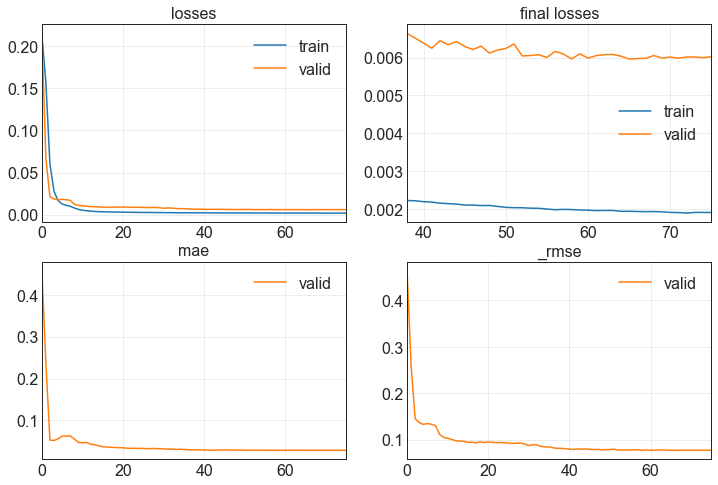

33.52044224739075                                                                                                      
[0.0019056855235248804, 0.00602389220148325, 0.028335217386484146, 0.07761373370885849]                                
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 66%|█████████████████████████████▋               | 66/100 [34:40<16:50, 29.72s/trial, best loss: 0.005229856353253126]

No improvement since epoch 69: early stopping                                                                          
 66%|█████████████████████████████▋               | 66/100 [35:13<16:50, 29.72s/trial, best loss: 0.005229856353253126]

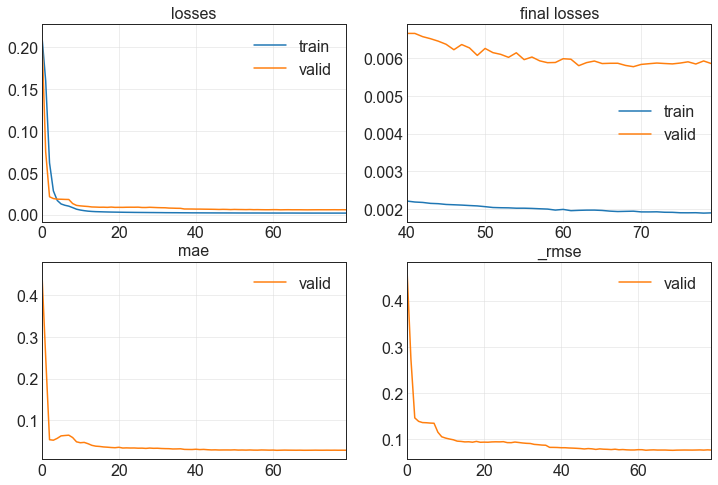

33.31725859642029                                                                                                      
[0.0018914691172540188, 0.00586076732724905, 0.02846045419573784, 0.07655564695596695]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 67%|██████████████████████████████▏              | 67/100 [35:15<17:10, 31.23s/trial, best loss: 0.005229856353253126]

No improvement since epoch 85: early stopping                                                                          
 67%|██████████████████████████████▏              | 67/100 [35:55<17:10, 31.23s/trial, best loss: 0.005229856353253126]

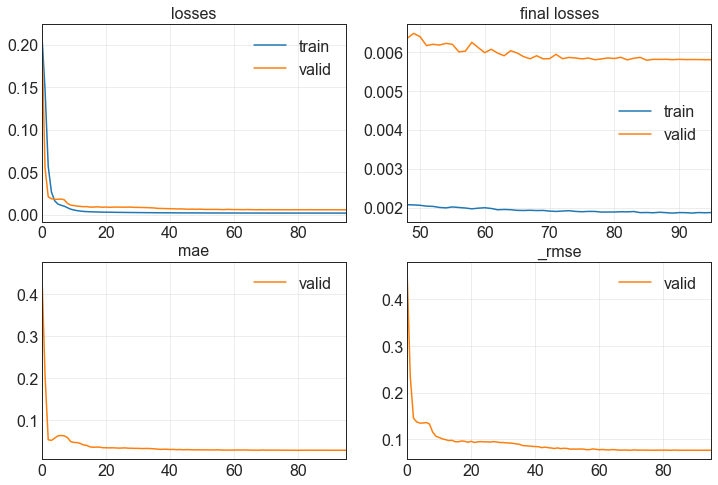

40.03068566322327                                                                                                      
[0.001872220658697188, 0.005797146819531918, 0.02825651317834854, 0.07613899558782578]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 68%|██████████████████████████████▌              | 68/100 [35:57<18:17, 34.30s/trial, best loss: 0.005229856353253126]

No improvement since epoch 62: early stopping                                                                          
 68%|██████████████████████████████▌              | 68/100 [36:27<18:17, 34.30s/trial, best loss: 0.005229856353253126]

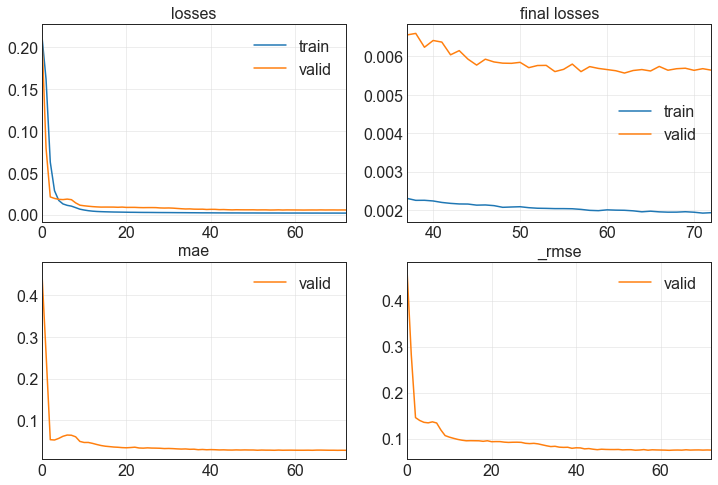

30.742842197418213                                                                                                     
[0.0019279815023764968, 0.0056420182809233665, 0.027810515835881233, 0.07511336356401443]                              
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 69%|███████████████████████████████              | 69/100 [36:29<17:23, 33.66s/trial, best loss: 0.005229856353253126]

No improvement since epoch 66: early stopping                                                                          
 69%|███████████████████████████████              | 69/100 [37:00<17:23, 33.66s/trial, best loss: 0.005229856353253126]

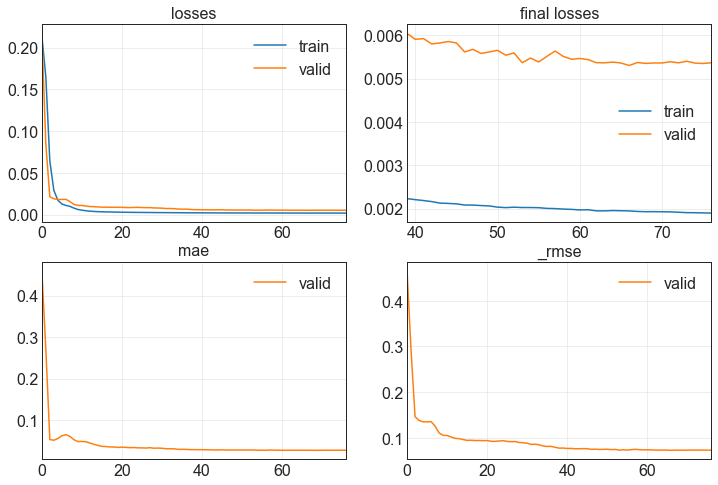

32.03685450553894                                                                                                      
[0.0018969833618029952, 0.005366389639675617, 0.027442803606390953, 0.07325565069913864]                               
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 70%|███████████████████████████████▍             | 70/100 [37:02<16:48, 33.60s/trial, best loss: 0.005229856353253126]

No improvement since epoch 57: early stopping                                                                          
 70%|███████████████████████████████▍             | 70/100 [37:30<16:48, 33.60s/trial, best loss: 0.005229856353253126]

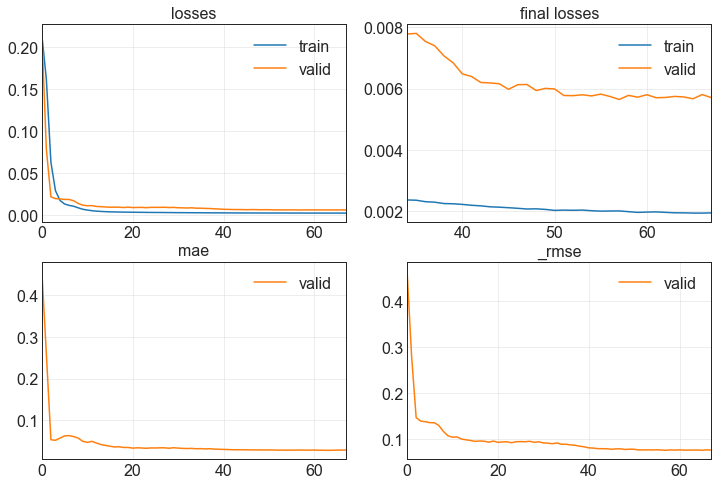

28.047267198562622                                                                                                     
[0.0019386430503800511, 0.005703109782189131, 0.028429696336388588, 0.07551894336938858]                               
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.01, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 71%|███████████████████████████████▉             | 71/100 [37:32<15:38, 32.36s/trial, best loss: 0.005229856353253126]

No improvement since epoch 37: early stopping                                                                          
 71%|███████████████████████████████▉             | 71/100 [37:51<15:38, 32.36s/trial, best loss: 0.005229856353253126]

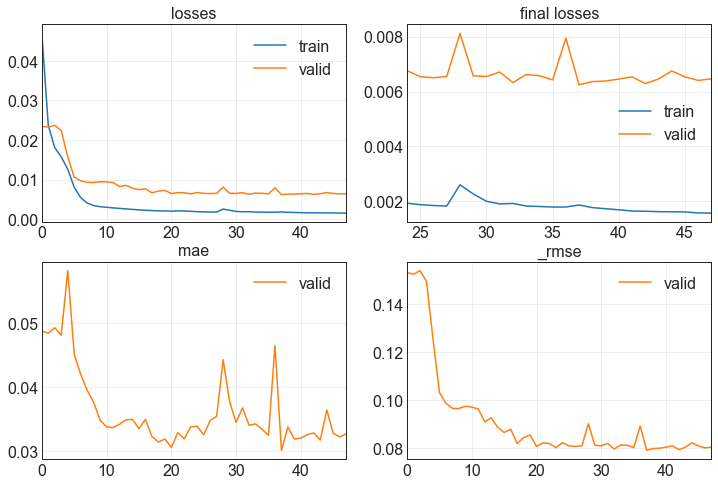

20.1305091381073                                                                                                       
[0.0015672275330871344, 0.006464038509875536, 0.032693006098270416, 0.08039924502372742]                               
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.1, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 72%|████████████████████████████████▍            | 72/100 [37:53<13:35, 29.13s/trial, best loss: 0.005229856353253126]

No improvement since epoch 0: early stopping                                                                           
 72%|████████████████████████████████▍            | 72/100 [37:58<13:35, 29.13s/trial, best loss: 0.005229856353253126]

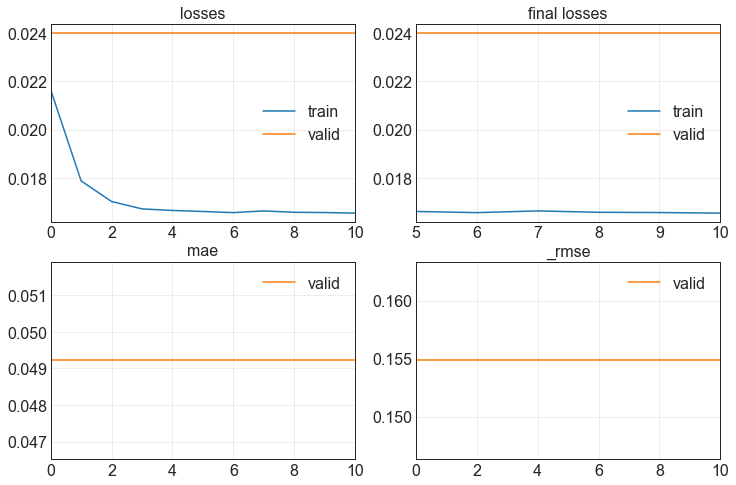

4.942000865936279                                                                                                      
[0.016544479876756668, 0.023975994437932968, 0.049219612032175064, 0.1548418402671814]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 73%|████████████████████████████████▊            | 73/100 [38:00<10:02, 22.30s/trial, best loss: 0.005229856353253126]

No improvement since epoch 64: early stopping                                                                          
 73%|████████████████████████████████▊            | 73/100 [38:30<10:02, 22.30s/trial, best loss: 0.005229856353253126]

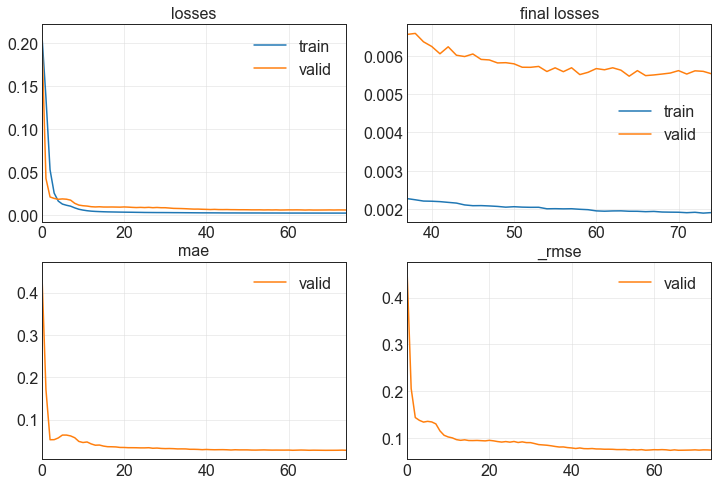

30.969752073287964                                                                                                     
[0.0019074470037594438, 0.005531900096684694, 0.027683807536959648, 0.07437674701213837]                               
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 74%|█████████████████████████████████▎           | 74/100 [38:32<10:58, 25.33s/trial, best loss: 0.005229856353253126]

No improvement since epoch 62: early stopping                                                                          
 74%|█████████████████████████████████▎           | 74/100 [39:01<10:58, 25.33s/trial, best loss: 0.005229856353253126]

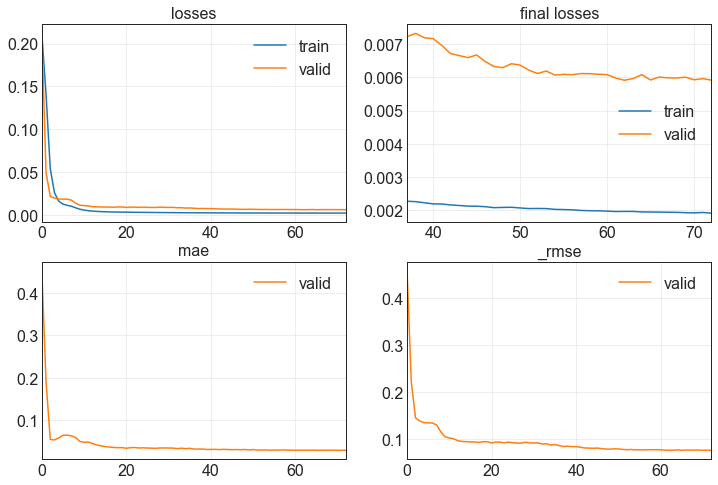

29.378264665603638                                                                                                     
[0.0019119554199278355, 0.005920579191297293, 0.02838689647614956, 0.07694529742002487]                                
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 20, 'fc_dropout': 0.5, 'layers': (100, 100, 100), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 75%|█████████████████████████████████▊           | 75/100 [39:03<11:14, 26.97s/trial, best loss: 0.005229856353253126]

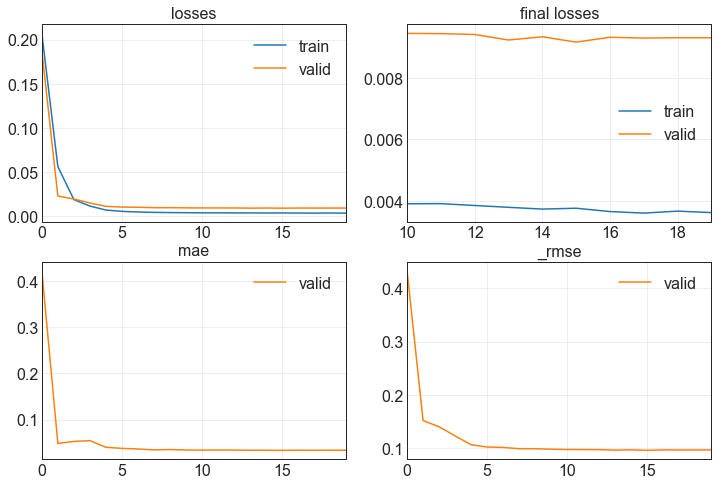

13.728243589401245                                                                                                     
[0.003617048030719161, 0.009309588000178337, 0.03321545198559761, 0.09648620337247849]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 50, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 76%|██████████████████████████████████▏          | 76/100 [39:18<09:21, 23.41s/trial, best loss: 0.005229856353253126]

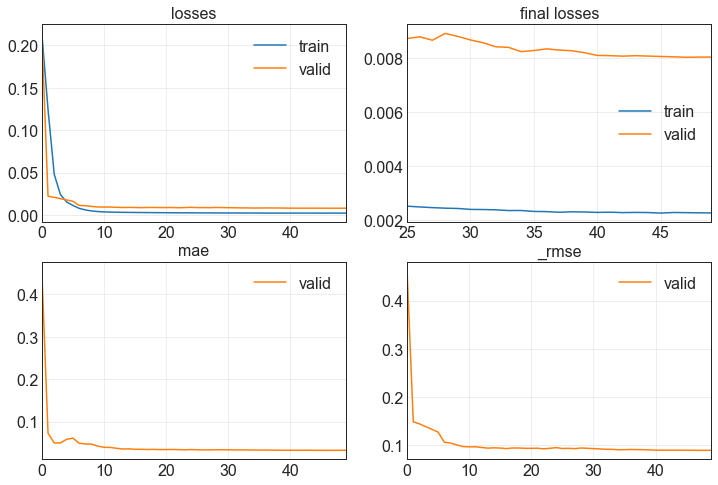

20.76524519920349                                                                                                      
[0.0022791449446231127, 0.008048725314438343, 0.03214371204376221, 0.08971468359231949]                                
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 77%|██████████████████████████████████▋          | 77/100 [39:40<08:50, 23.05s/trial, best loss: 0.005229856353253126]

No improvement since epoch 48: early stopping                                                                          
 77%|██████████████████████████████████▋          | 77/100 [40:57<08:50, 23.05s/trial, best loss: 0.005229856353253126]

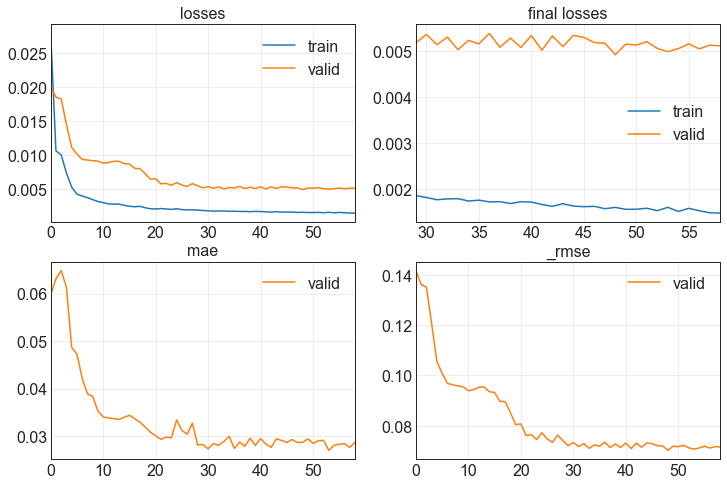

77.68713617324829                                                                                                      
[0.001472705276682973, 0.005122148431837559, 0.028756195679306984, 0.07156917452812195]                                
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 78%|███████████████████████████████████          | 78/100 [40:59<14:37, 39.88s/trial, best loss: 0.005122148431837559]

No improvement since epoch 60: early stopping                                                                          
 78%|███████████████████████████████████          | 78/100 [42:27<14:37, 39.88s/trial, best loss: 0.005122148431837559]

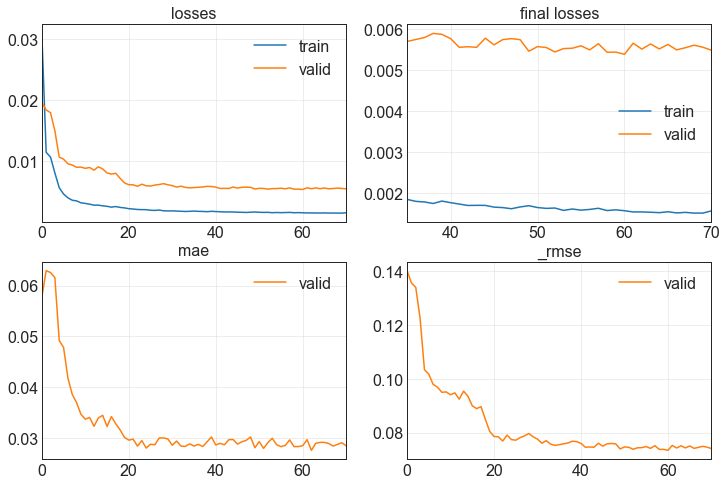

88.54149460792542                                                                                                      
[0.001567396568134427, 0.005485984496772289, 0.028508855029940605, 0.07406742870807648]                                
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 79%|███████████████████████████████████▌         | 79/100 [42:29<19:13, 54.92s/trial, best loss: 0.005122148431837559]

No improvement since epoch 50: early stopping                                                                          
 79%|███████████████████████████████████▌         | 79/100 [43:47<19:13, 54.92s/trial, best loss: 0.005122148431837559]

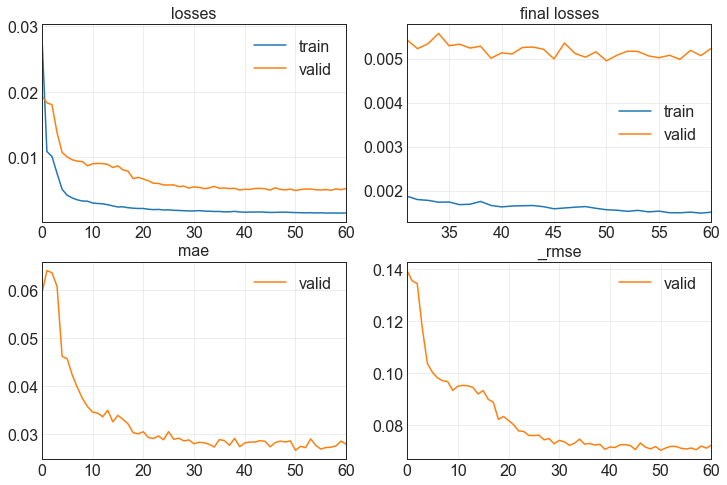

78.25078177452087                                                                                                      
[0.0015114729758352041, 0.005233502481132746, 0.027885600924491882, 0.07234294712543488]                               
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 20, 'fc_dropout': 0.5, 'layers': (100, 100, 100), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 80%|████████████████████████████████████         | 80/100 [43:49<20:46, 62.34s/trial, best loss: 0.005122148431837559]

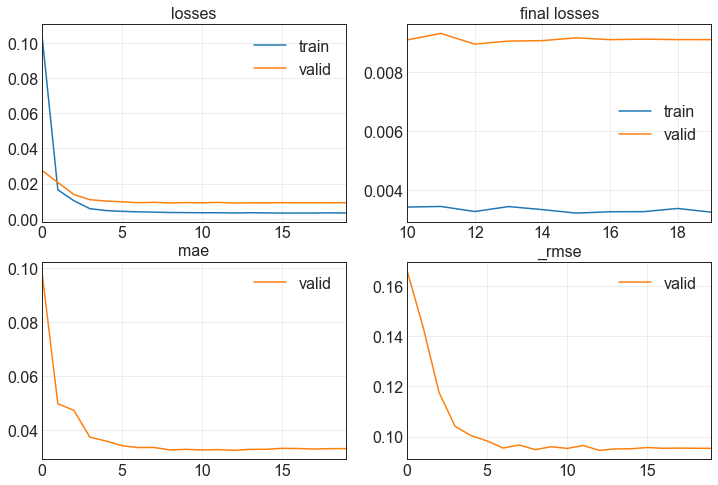

24.390499114990234                                                                                                     
[0.003240305231884122, 0.009091301821172237, 0.03310421109199524, 0.09534832090139389]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 5}
MLP                                                                                                                    
 81%|████████████████████████████████████▍        | 81/100 [44:15<16:16, 51.38s/trial, best loss: 0.005122148431837559]

No improvement since epoch 28: early stopping                                                                          
 81%|████████████████████████████████████▍        | 81/100 [45:00<16:16, 51.38s/trial, best loss: 0.005122148431837559]

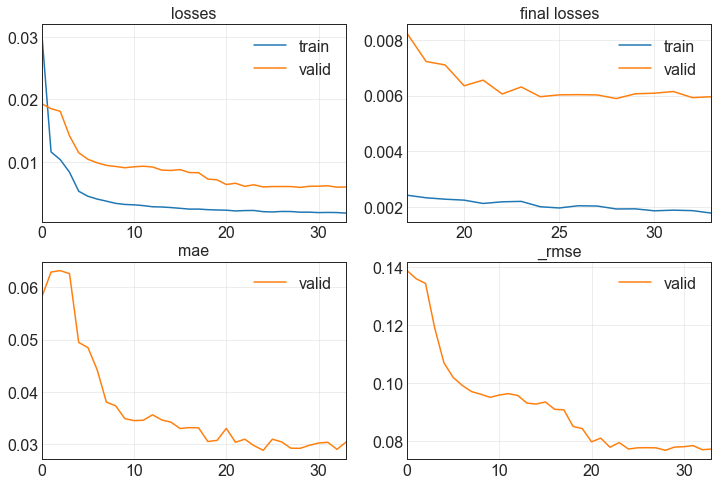

45.390939235687256                                                                                                     
[0.0017765917582437396, 0.005960165057331324, 0.0304415263235569, 0.07720210403203964]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 50, 'fc_dropout': 0.1, 'layers': (200, 200, 200), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 82%|████████████████████████████████████▉        | 82/100 [45:02<15:00, 50.02s/trial, best loss: 0.005122148431837559]

No improvement since epoch 36: early stopping                                                                          
 82%|████████████████████████████████████▉        | 82/100 [46:00<15:00, 50.02s/trial, best loss: 0.005122148431837559]

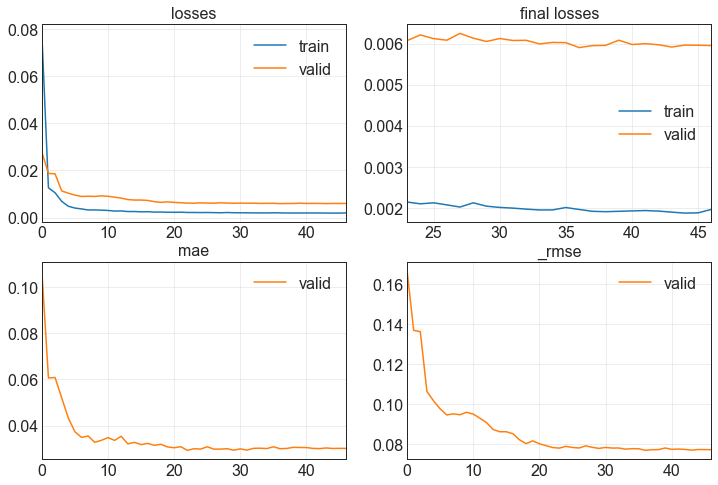

59.28013586997986                                                                                                      
[0.0019618512596935034, 0.005950507242232561, 0.03013055957853794, 0.07713952660560608]                                
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 83%|█████████████████████████████████████▎       | 83/100 [46:02<15:05, 53.24s/trial, best loss: 0.005122148431837559]

No improvement since epoch 46: early stopping                                                                          
 83%|█████████████████████████████████████▎       | 83/100 [47:19<15:05, 53.24s/trial, best loss: 0.005122148431837559]

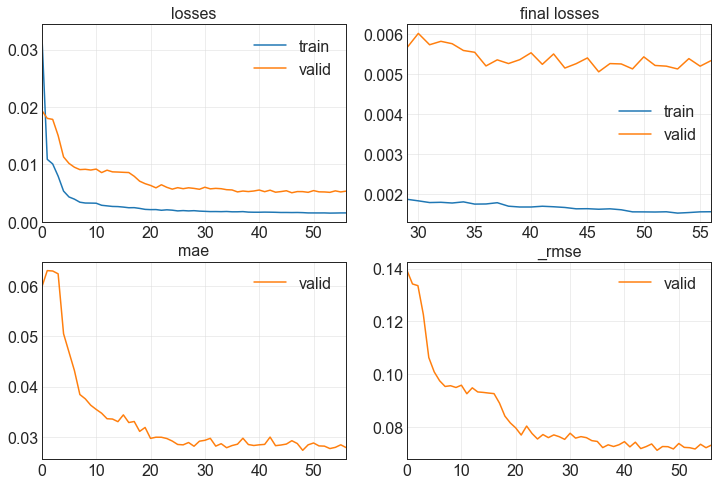

77.3835391998291                                                                                                       
[0.0015521226450800896, 0.00534621998667717, 0.027842625975608826, 0.07311785966157913]                                
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 5}
MLP                                                                                                                    
 84%|█████████████████████████████████████▊       | 84/100 [47:21<16:14, 60.93s/trial, best loss: 0.005122148431837559]

No improvement since epoch 34: early stopping                                                                          
 84%|█████████████████████████████████████▊       | 84/100 [48:14<16:14, 60.93s/trial, best loss: 0.005122148431837559]

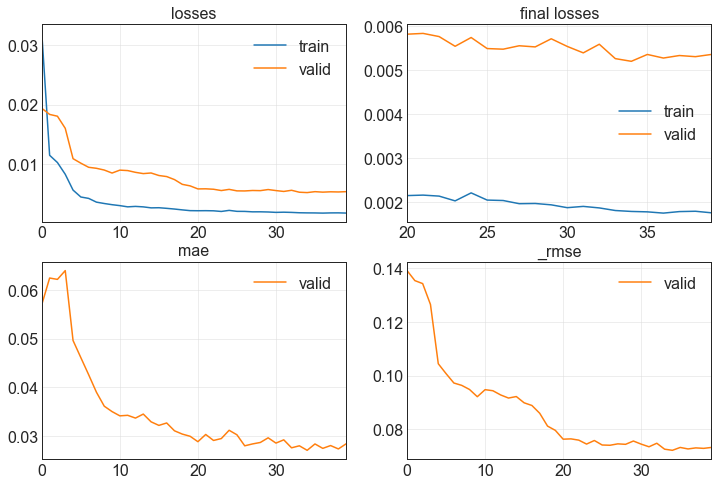

52.93454694747925                                                                                                      
[0.0017563606379553676, 0.005355107598006725, 0.028435364365577698, 0.07317860424518585]                               
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.1, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 85%|██████████████████████████████████████▎      | 85/100 [48:16<14:44, 59.00s/trial, best loss: 0.005122148431837559]

No improvement since epoch 0: early stopping                                                                           
 85%|██████████████████████████████████████▎      | 85/100 [48:30<14:44, 59.00s/trial, best loss: 0.005122148431837559]

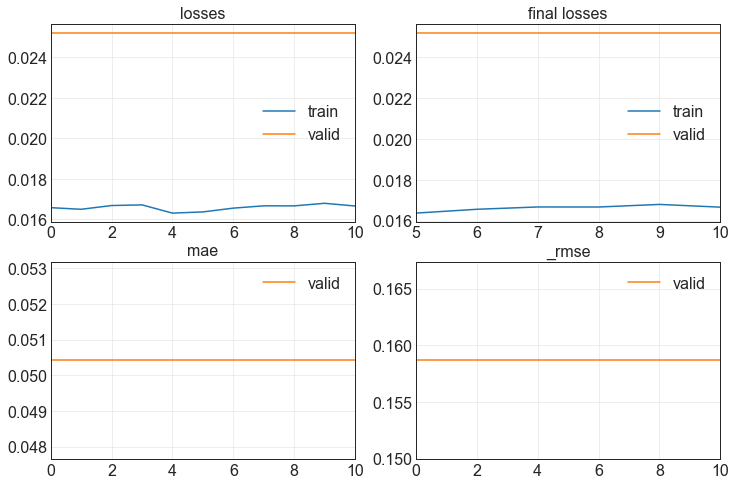

14.87212324142456                                                                                                      
[0.016660885885357857, 0.025174330919981003, 0.0504179373383522, 0.15866421163082123]                                  
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 20, 'fc_dropout': 0.2, 'layers': (200, 200, 200), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 86%|██████████████████████████████████████▋      | 86/100 [48:32<10:46, 46.19s/trial, best loss: 0.005122148431837559]

No improvement since epoch 9: early stopping                                                                           
 86%|██████████████████████████████████████▋      | 86/100 [48:58<10:46, 46.19s/trial, best loss: 0.005122148431837559]

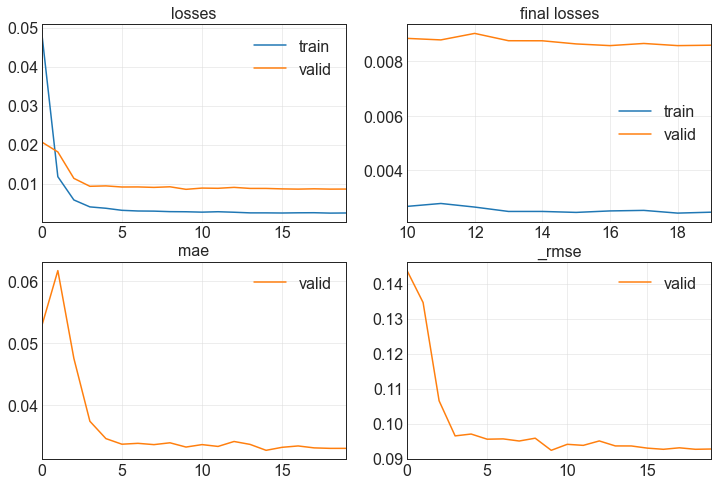

26.741752862930298                                                                                                     
[0.0024649938568472862, 0.008597884327173233, 0.03303692117333412, 0.09272477775812149]                                
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 100, 'fc_dropout': 0.5, 'layers': (100, 100, 100), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 87%|███████████████████████████████████████▏     | 87/100 [49:00<08:50, 40.81s/trial, best loss: 0.005122148431837559]

No improvement since epoch 67: early stopping                                                                          
 87%|███████████████████████████████████████▏     | 87/100 [50:37<08:50, 40.81s/trial, best loss: 0.005122148431837559]

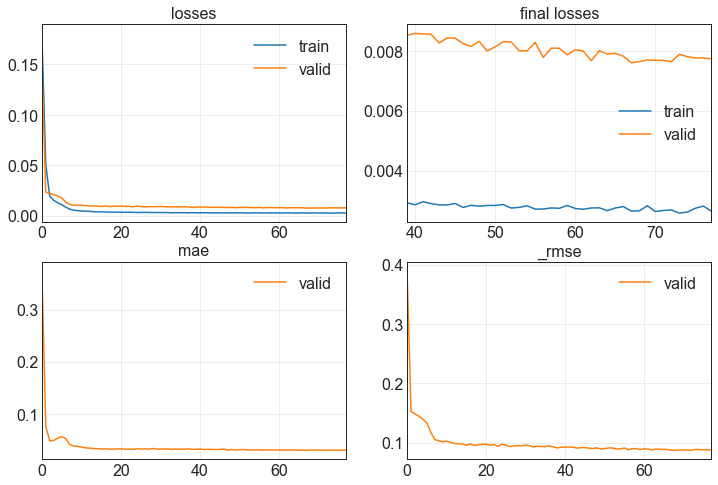

97.08626103401184                                                                                                      
[0.002642553998157382, 0.007735265884548426, 0.030462000519037247, 0.08795035630464554]                                
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 50, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 5}
MLP                                                                                                                    
 88%|███████████████████████████████████████▌     | 88/100 [50:39<11:37, 58.13s/trial, best loss: 0.005122148431837559]

No improvement since epoch 25: early stopping                                                                          
 88%|███████████████████████████████████████▌     | 88/100 [51:19<11:37, 58.13s/trial, best loss: 0.005122148431837559]

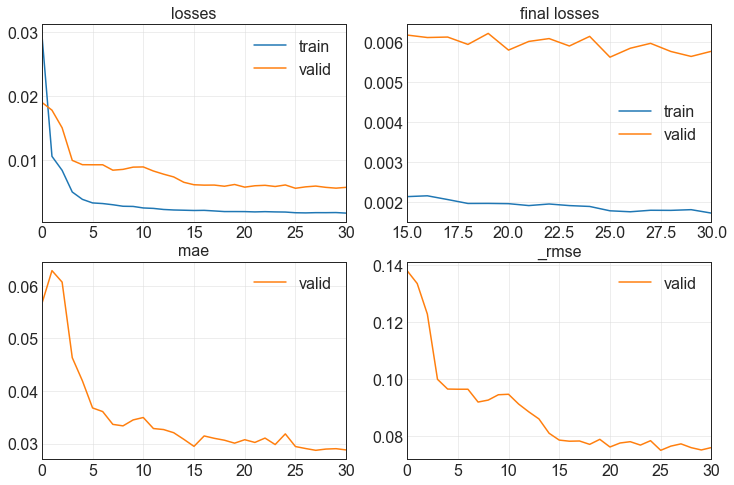

40.2533061504364                                                                                                       
[0.0017326464876532555, 0.005765862297266722, 0.028791455551981926, 0.07593327015638351]                               
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (500, 500, 500), 'lr': 0.1, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 89%|████████████████████████████████████████     | 89/100 [51:21<09:45, 53.19s/trial, best loss: 0.005122148431837559]

No improvement since epoch 0: early stopping                                                                           
 89%|████████████████████████████████████████     | 89/100 [51:34<09:45, 53.19s/trial, best loss: 0.005122148431837559]

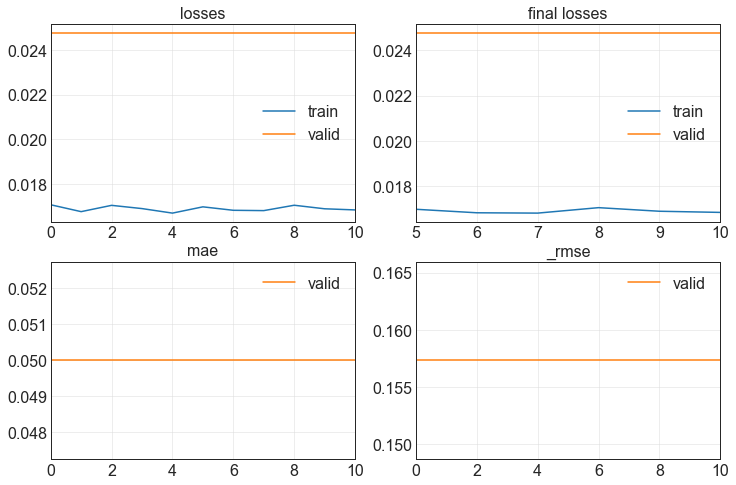

14.221508979797363                                                                                                     
[0.0168311670422554, 0.0247462410479784, 0.04998984560370445, 0.15730935335159302]                                     
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 90%|████████████████████████████████████████▌    | 90/100 [51:36<06:59, 41.95s/trial, best loss: 0.005122148431837559]

No improvement since epoch 29: early stopping                                                                          
 90%|████████████████████████████████████████▌    | 90/100 [52:29<06:59, 41.95s/trial, best loss: 0.005122148431837559]

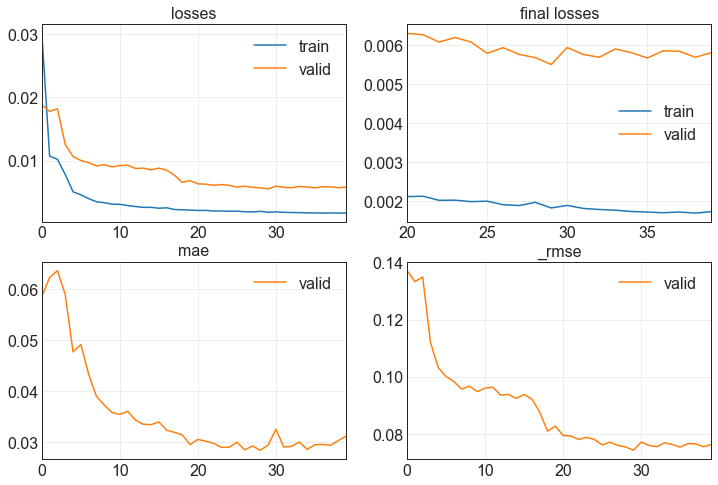

52.95280694961548                                                                                                      
[0.00172141392249614, 0.005810815375298262, 0.03113291785120964, 0.07622870802879333]                                  
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (200, 200, 200), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 91%|████████████████████████████████████████▉    | 91/100 [52:31<06:51, 45.69s/trial, best loss: 0.005122148431837559]

No improvement since epoch 31: early stopping                                                                          
 91%|████████████████████████████████████████▉    | 91/100 [53:21<06:51, 45.69s/trial, best loss: 0.005122148431837559]

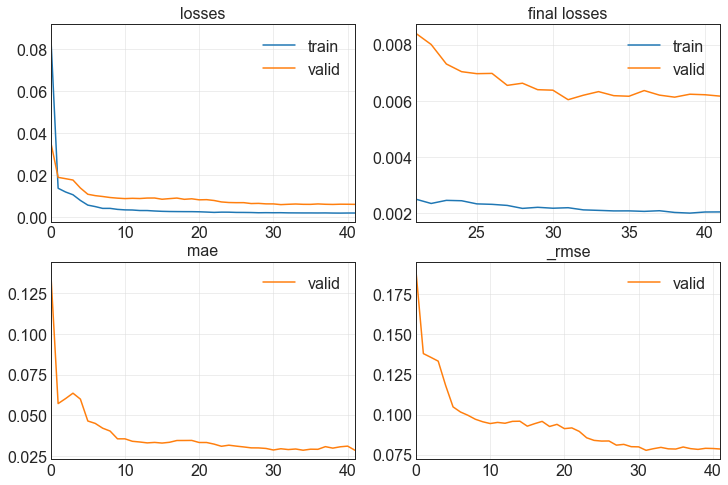

50.361552000045776                                                                                                     
[0.002035660669207573, 0.006165097933262587, 0.02832868881523609, 0.07851812988519669]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 20, 'fc_dropout': 0.5, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 92%|█████████████████████████████████████████▍   | 92/100 [53:22<06:20, 47.52s/trial, best loss: 0.005122148431837559]

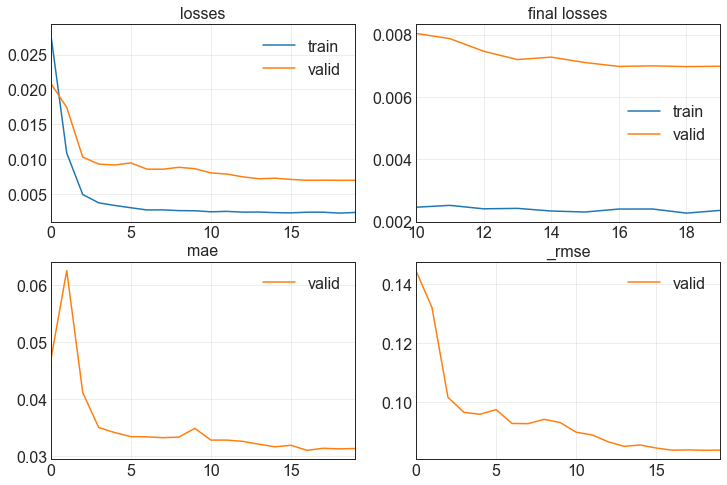

24.87241840362549                                                                                                      
[0.0023635525722056627, 0.00698489136993885, 0.03136682137846947, 0.08357565850019455]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 50, 'fc_dropout': 0.1, 'layers': (100, 100, 100), 'lr': 0.1, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 5}
MLP                                                                                                                    
 93%|█████████████████████████████████████████▊   | 93/100 [53:49<04:48, 41.15s/trial, best loss: 0.005122148431837559]

No improvement since epoch 0: early stopping                                                                           
 93%|█████████████████████████████████████████▊   | 93/100 [53:56<04:48, 41.15s/trial, best loss: 0.005122148431837559]

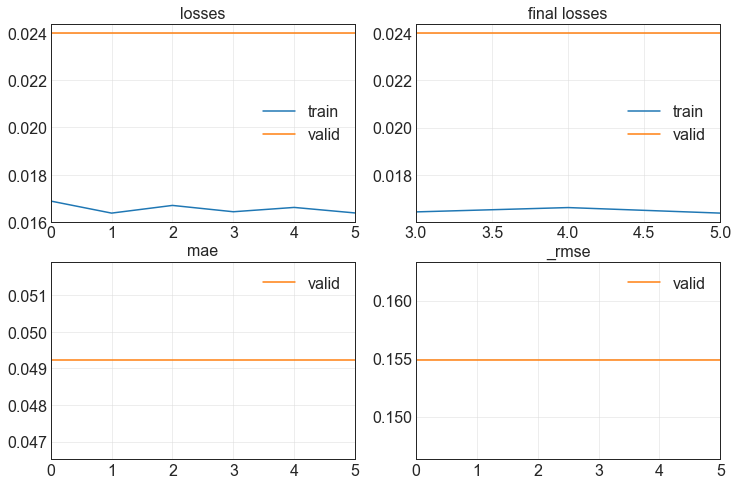

7.3911237716674805                                                                                                     
[0.01638585887849331, 0.023976000025868416, 0.049219608306884766, 0.1548418402671814]                                  
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 94%|██████████████████████████████████████████▎  | 94/100 [53:57<03:08, 31.43s/trial, best loss: 0.005122148431837559]

No improvement since epoch 42: early stopping                                                                          
 94%|██████████████████████████████████████████▎  | 94/100 [55:57<03:08, 31.43s/trial, best loss: 0.005122148431837559]

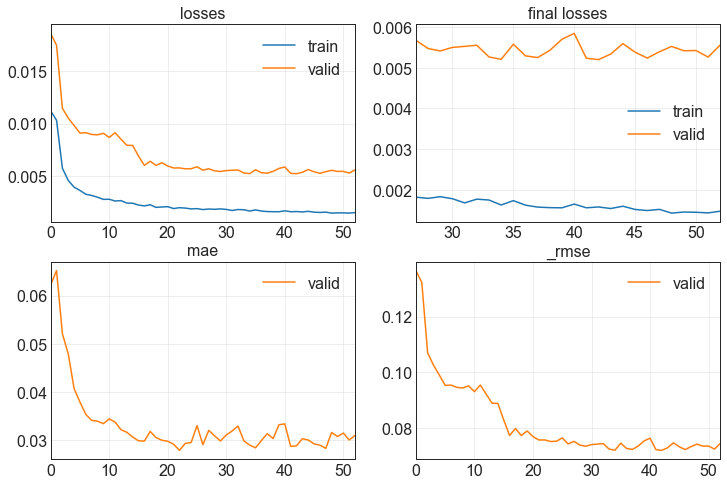

120.39240050315857                                                                                                     
[0.001474209246225655, 0.0055610984563827515, 0.031036892905831337, 0.07457277178764343]                               
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.01, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 95%|██████████████████████████████████████████▊  | 95/100 [55:59<04:52, 58.54s/trial, best loss: 0.005122148431837559]

No improvement since epoch 25: early stopping                                                                          
 95%|██████████████████████████████████████████▊  | 95/100 [56:26<04:52, 58.54s/trial, best loss: 0.005122148431837559]

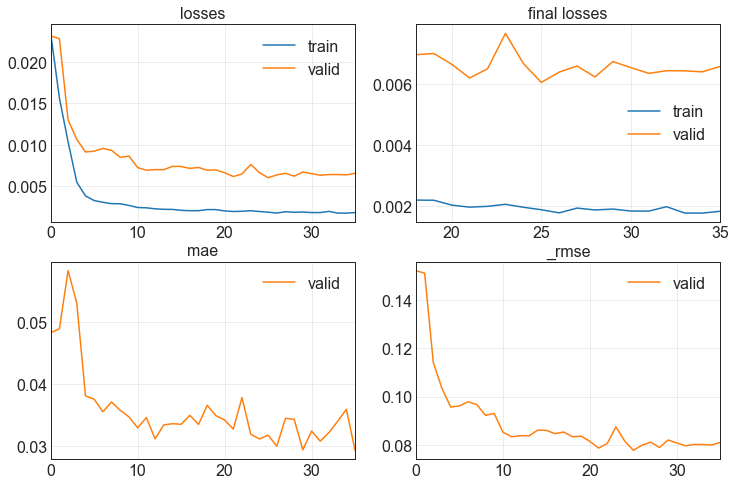

27.161097049713135                                                                                                     
[0.0018323749536648393, 0.006567313801497221, 0.02933250553905964, 0.08103896677494049]                                
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (200, 200, 200), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 96%|███████████████████████████████████████████▏ | 96/100 [56:28<03:18, 49.56s/trial, best loss: 0.005122148431837559]

No improvement since epoch 34: early stopping                                                                          
 96%|███████████████████████████████████████████▏ | 96/100 [57:23<03:18, 49.56s/trial, best loss: 0.005122148431837559]

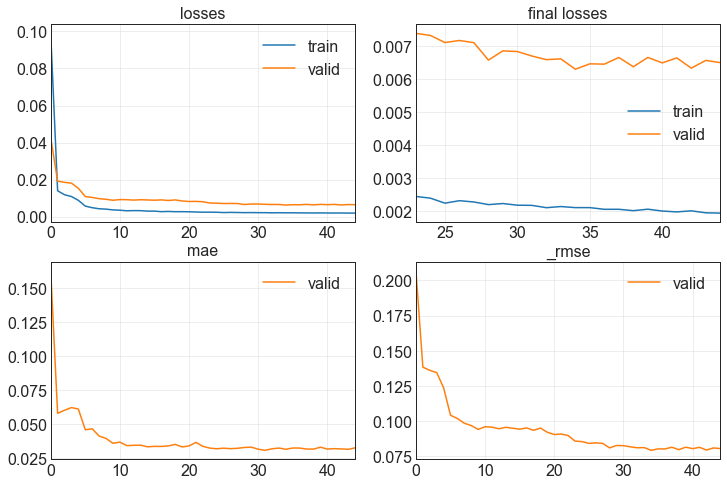

56.078216552734375                                                                                                     
[0.0019451164407655597, 0.006498920731246471, 0.032399117946624756, 0.08061588555574417]                               
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.1, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 5}
MLP                                                                                                                    
 97%|███████████████████████████████████████████▋ | 97/100 [57:25<02:35, 51.94s/trial, best loss: 0.005122148431837559]

No improvement since epoch 0: early stopping                                                                           
 97%|███████████████████████████████████████████▋ | 97/100 [57:33<02:35, 51.94s/trial, best loss: 0.005122148431837559]

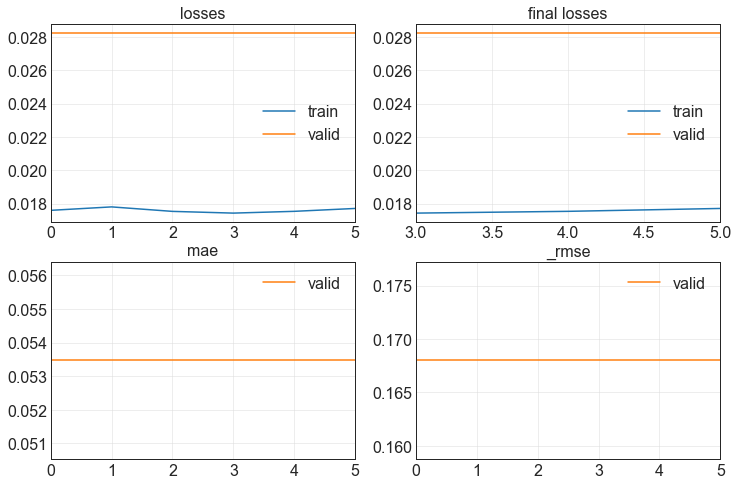

8.072971105575562                                                                                                      
[0.01771029271185398, 0.028222279623150826, 0.053465887904167175, 0.16799487173557281]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 20, 'fc_dropout': 0.5, 'layers': (500, 500, 500), 'lr': 0.01, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 98%|████████████████████████████████████████████ | 98/100 [57:35<01:18, 39.22s/trial, best loss: 0.005122148431837559]

No improvement since epoch 4: early stopping                                                                           
 98%|████████████████████████████████████████████ | 98/100 [58:12<01:18, 39.22s/trial, best loss: 0.005122148431837559]

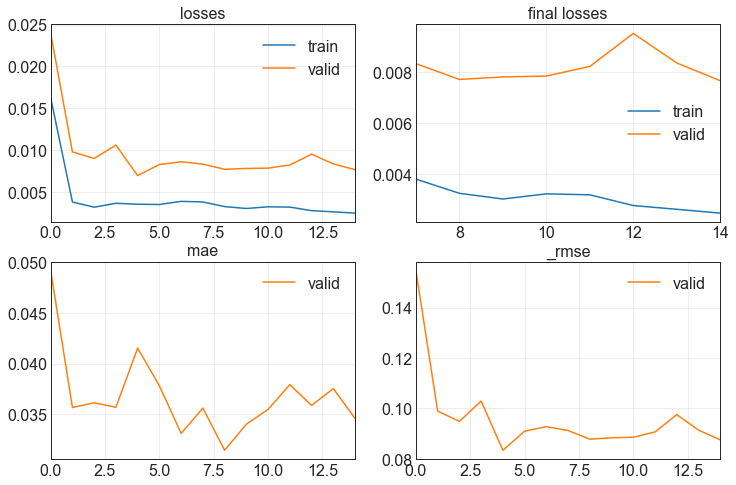

38.079432249069214                                                                                                     
[0.0024665812961757183, 0.007653962820768356, 0.03460189327597618, 0.08748693764209747]                                
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 50, 'fc_dropout': 0.1, 'layers': (100, 100, 100), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}
MLP                                                                                                                    
 99%|████████████████████████████████████████████▌| 99/100 [58:14<00:39, 39.30s/trial, best loss: 0.005122148431837559]

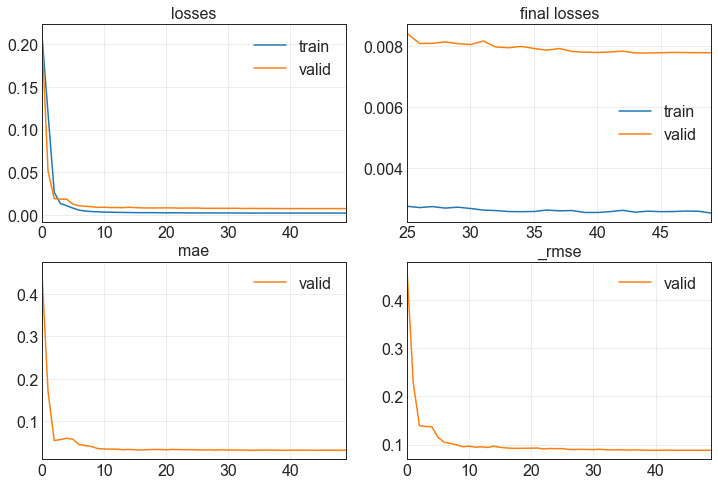

35.32395029067993                                                                                                      
[0.0025087380781769753, 0.0077903917990624905, 0.031940702348947525, 0.08826319873332977]                              
100%|████████████████████████████████████████████| 100/100 [58:50<00:00, 35.30s/trial, best loss: 0.005122148431837559]


In [57]:
trials = Trials()
best = fmin(create_model_hypopt,
    space=search_space,
    algo=tpe.suggest,
    max_evals=max_evals,  # test trials
    trials=trials)

In [58]:
print("Best parameters:")
print(space_eval(search_space, best))
params = space_eval(search_space, best)

Best parameters:
{'batch_size': 32, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x00000229A7316438>, 'patience': 10}


In [59]:
# only for debug
# params = {'batch_size': 16, 'bidirectional': False, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 5, 'optimizer': Adam, 'patience': 10}

# Retrain the model with best hyperparameter

We use training data for training and validation data for (possible) early stopping:

In [60]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [61]:
X.shape

(8606, 529, 10)

In [62]:
y.shape

(8606, 529)

In [63]:
batch_size = params["batch_size"]

In [64]:
tfms  = [None, [TSRegression()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
# set num_workers for memory bottleneck
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)

Create the model:

In [65]:
arch = MLP
k = {
    'layers': params['layers'],
    'fc_dropout': params['fc_dropout']
}
model = create_model(arch, dls=dls, **k)
print(model.__class__.__name__)

MLP


In [66]:
# Add a Sigmoid layer
model = nn.Sequential(model, nn.Sigmoid())

In [67]:
model

Sequential(
  (0): MLP(
    (flatten): Reshape(bs, -1)
    (mlp): ModuleList(
      (0): LinBnDrop(
        (0): Dropout(p=0.1, inplace=False)
        (1): Linear(in_features=5290, out_features=500, bias=True)
        (2): ReLU(inplace=True)
      )
      (1): LinBnDrop(
        (0): Dropout(p=0.2, inplace=False)
        (1): Linear(in_features=500, out_features=500, bias=True)
        (2): ReLU(inplace=True)
      )
      (2): LinBnDrop(
        (0): Dropout(p=0.2, inplace=False)
        (1): Linear(in_features=500, out_features=500, bias=True)
        (2): ReLU(inplace=True)
      )
    )
    (head): Sequential(
      (0): LinBnDrop(
        (0): Dropout(p=0.1, inplace=False)
        (1): Linear(in_features=500, out_features=529, bias=True)
      )
    )
  )
  (1): Sigmoid()
)

In [68]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

3,411,529 total parameters.
3,411,529 training parameters.


Training the model:

No improvement since epoch 38: early stopping


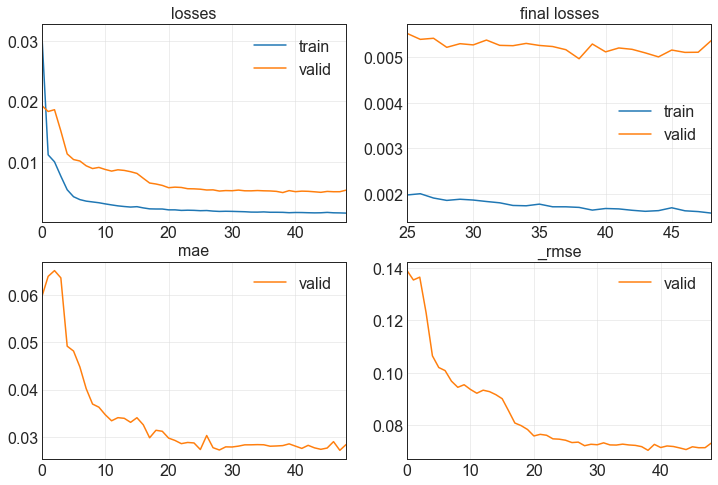

In [69]:
learn = Learner(dls, model, metrics=[mae, rmse], opt_func=params['optimizer'])
start = time.time()
learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                    cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
training_time = time.time() - start
learn.plot_metrics()

Evaluate the model:

In [70]:
dls = learn.dls
valid_dl = dls.valid

In [71]:
test_ds = valid_dl.dataset.add_test(X_test, y_test)  # use the test data
test_dl = valid_dl.new(test_ds)
print(test_dl.n)

2153


In [72]:
start = time.time()
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
prediction_time = time.time() - start
test_probas, test_targets, test_preds

(tensor([[0.0018, 0.0451, 0.0350,  ..., 0.0035, 0.0022, 0.0019],
         [0.0017, 0.0445, 0.0350,  ..., 0.0034, 0.0021, 0.0017],
         [0.0016, 0.0435, 0.0331,  ..., 0.0032, 0.0019, 0.0017],
         ...,
         [0.0021, 0.0183, 0.0231,  ..., 0.0040, 0.0023, 0.0022],
         [0.0021, 0.0182, 0.0237,  ..., 0.0039, 0.0023, 0.0022],
         [0.0022, 0.0191, 0.0252,  ..., 0.0041, 0.0024, 0.0023]]),
 tensor([[0.0000e+00, 4.2537e-04, 9.6929e-04,  ..., 4.5983e-04, 1.2533e-04,
          0.0000e+00],
         [0.0000e+00, 1.6241e-04, 3.8517e-04,  ..., 5.4193e-04, 8.0880e-05,
          0.0000e+00],
         [0.0000e+00, 2.2912e-04, 1.9301e-03,  ..., 4.0765e-04, 1.9965e-04,
          0.0000e+00],
         ...,
         [0.0000e+00, 4.7334e-03, 0.0000e+00,  ..., 1.2775e-03, 0.0000e+00,
          0.0000e+00],
         [0.0000e+00, 6.2943e-03, 0.0000e+00,  ..., 1.1132e-03, 2.1495e-04,
          0.0000e+00],
         [0.0000e+00, 1.3714e-02, 0.0000e+00,  ..., 1.7625e-04, 0.0000e+00,
         

In [73]:
test_targets.shape

torch.Size([2153, 529])

In [74]:
test_preds.shape

torch.Size([2153, 529])

In [75]:
y_true = test_targets.numpy()
y_pred = test_preds.numpy()

Reshape the data into multiple steps

In [76]:
y_true = y_true.reshape(y_true.shape[0], horizon, -1)
y_pred = y_pred.reshape(y_pred.shape[0], horizon, -1)

In [77]:
y_true.shape

(2153, 1, 529)

In [78]:
y_pred.shape

(2153, 1, 529)

Transform the data in the normal range:

In [79]:
def inverse_normalization(prediction, y, max_list, min_list):
    inverse_prediction = prediction * (max_list - min_list) + min_list
    inverse_y = y * (max_list - min_list) + min_list

    return inverse_prediction, inverse_y

In [80]:
y_true_list = []
y_pred_list = []
for i in range(y_true.shape[0]):
    y_true_tmp = []
    y_pred_tmp = []
    for step in range(y_true.shape[1]):
        inverse_prediction, inverse_y = inverse_normalization(y_pred[i, step, :], y_true[i, step, :], max_list, min_list)
        
        y_true_tmp.append(inverse_y)
        y_pred_tmp.append(inverse_prediction)
    y_true_list.append(y_true_tmp)
    y_pred_list.append(y_pred_tmp)

In [81]:
y_true = np.array(y_true_list)
y_pred = np.array(y_pred_list)

In [82]:
y_true.shape

(2153, 1, 529)

In [83]:
y_pred.shape

(2153, 1, 529)

# Save Predictions and Evaluate Model

Save true values and predictions first:

In [84]:
pickle.dump(y_pred, open(y_pred_fn, 'wb'))

In [85]:
pickle.dump(y_true, open(y_true_fn, 'wb'))

The training and test time spent:

In [86]:
print('Training time (in seconds): ', training_time)
print('Test time (in seconds): ', prediction_time)

Training time (in seconds):  61.92123007774353
Test time (in seconds):  0.25999951362609863


In [92]:
print('Training time (in seconds) per epoch: ', 61.92123007774353 / 49)

Training time (in seconds) per epoch:  1.2636985730151742


Calculate the RMSE and MAE for differnt time steps:

In [88]:
for step in range(horizon):
    print('Prediction for the next %d frame' % (step + 1))
    print('RMSE: ', math.sqrt(mean_squared_error(y_true[:, step, :].flatten(), y_pred[:, step, :].flatten())) / 1000)  # in Mbps
    print('MAE: ', mean_absolute_error(y_true[:, step, :].flatten(), y_pred[:, step, :].flatten()) / 1000 )

Prediction for the next 1 frame
RMSE:  19.036076090659495
MAE:  6.411971636487754


Plot the RMSE and MAE distributions for each time step:

In [89]:
def plot_RMSE(y_true, y_pred, fn, xlim=60):
    RMSE_list = []

    for i in range(y_true.shape[0]):
        rmse = math.sqrt(mean_squared_error(y_true[i].flatten(), y_pred[i].flatten())) / 1000
        RMSE_list.append(rmse)
    
    data = RMSE_list
    data_size = len(data)
    data_set = sorted(set(data))
    bins = np.append(data_set, data_set[-1] + 1)

    # Use the histogram function to bin the data
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    counts = counts.astype(float) / data_size
    
    plt.figure(figsize=[12, 9])
    plt.xlabel("RMSE (Mbps)")
    plt.xlim((0, xlim))
    plt.ylabel("CDF")
    plt.ylim((0, 1))

    # Format the x tick labels
    ax = plt.gca()
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax.xaxis.set_major_formatter(formatter)

    cdf = np.cumsum(counts)
    plt.plot(bin_edges[0:-1], cdf)
    
    plt.savefig(fn, bbox_inches = 'tight', pad_inches = 0.1)

In [90]:
def plot_MAE(y_true, y_pred, fn, xlim=60):
    MAE_list = []

    for i in range(y_true.shape[0]):
        mae = mean_absolute_error(y_true[i].flatten(), y_pred[i].flatten()) / 1000
        MAE_list.append(mae)
    
    data = MAE_list
    data_size = len(data)
    data_set = sorted(set(data))
    bins = np.append(data_set, data_set[-1] + 1)

    # Use the histogram function to bin the data
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    counts = counts.astype(float) / data_size
    
    plt.figure(figsize=[12, 9])
    plt.xlabel("MAE (Mbps)")
    plt.xlim((0, xlim))
    plt.ylabel("CDF")
    plt.ylim((0, 1))

    # Format the x tick labels
    ax = plt.gca()
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax.xaxis.set_major_formatter(formatter)

    cdf = np.cumsum(counts)
    plt.plot(bin_edges[0:-1], cdf)
    
    plt.savefig(fn, bbox_inches = 'tight', pad_inches = 0.1)

MLP_TM-minmax_RMSE-10-1-step-1.pdf
MLP_TM-minmax_MAE-10-1-step-1.pdf


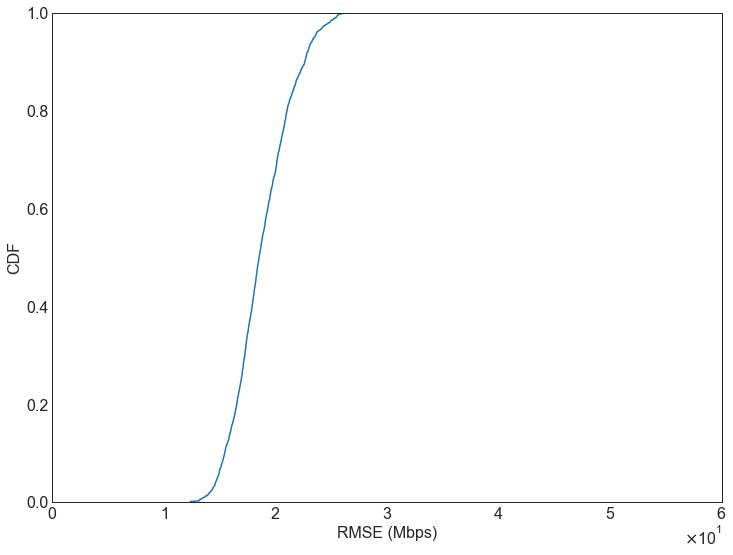

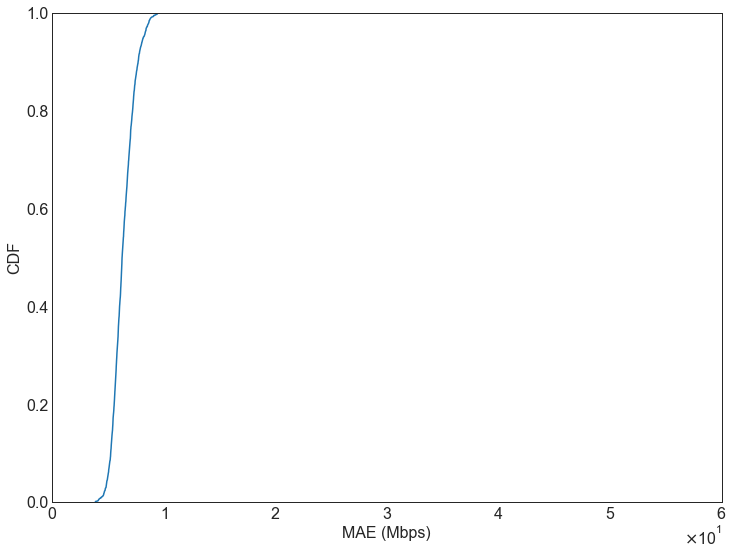

In [91]:
for step in range(horizon):
    fn = RMSE_fn % (history, horizon, step + 1)
    print(fn)
    
    plot_RMSE(y_true[:, step, :], y_pred[:, step, :], fn)
    
    fn = MAE_fn % (history, horizon, step + 1)
    print(fn)
    
    plot_MAE(y_true[:, step, :], y_pred[:, step, :], fn)